In [231]:
import sys
import numpy
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
from scipy.ndimage import label
import numpy as np
import ast
from scipy.ndimage import gaussian_filter
from matplotlib.colors import ListedColormap
import corner

def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None;
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [232]:
event_component_colors = {
    "GW190917_1": "#000000",  # black
    "GW190917_2": "#fa8072",  # salmon
    "GW230529_1": "#1e90ff",  # dodgerblue
    "GW190814_2": "#daa520",  # goldenrod
    "GW190425_2": "#87CEEB",  # skyblue
    "GW190425_1": "#228B22",  # forestgreen
    "GW200105_1": "#008080",  # teal
    "GW200105_2": "#8a2be2",  # blueviolet
    "GW200115_2": "#708090",  # slate grey
    "GW170817_1": "firebrick"
}

pop_parameter2latex = {"beta_1":r"$\beta_{\mathrm{low}}^\mathrm{BNS}$",
                       "mu_peak_NS":r"$\mu^{\mathrm{peak}}_{\mathrm{NS}}$",
                       "sig_peak_NS":r"$\sigma^{\mathrm{peak}}_{\mathrm{NS}}$",
                       "mu_costilt":r"$\mu_{\mathrm{cos}\theta}^{\rm NS}$",
                       "sigma_costilt":r"$\sigma_{\mathrm{cos}\theta}^{\rm NS}$",
                       "mu_chi1":r"$\mu_{\chi}^{\rm NS}$", 
                       "sig_chi1":r"$\sigma_{\chi}^{\rm NS}$",
                       "gamma_high":r"$\gamma_{\mathrm{high}}$",}

In [233]:
import os
import glob
import re
import pandas as pd
from tqdm import tqdm

def to_df(mmms_folder_name, pop_parameter, verbose = False):
    # Define pattern to match values from lines
    prob_pattern_pop = r"Probability: P\(mass <= max_mass\(spin, eos\)\) = ([\d\.eE+-]+) \+/- ([\d\.eE+-]+)"
    odds_pattern_pop = r"Odds Ratio\s*:.*= ([\d\.eE+-]+) \+/- ([\d\.eE+-]+)"

    prob_pattern_np = prob_pattern_pop
    odds_pattern_np = odds_pattern_pop

    prob_pattern_eos = r"Probability: P\(.*?\) = ([0-9.eE+-]+) \+/- ([0-9.eE+-]+)"
    odds_pattern_eos = r"Odds Ratio\s*:.*?= ([0-9.eE+-]+) \+/- ([0-9.eE+-]+)"


    # Create list to hold parsed data
    data = []

    # Loop through all .out files
    glob_path = f"../{mmms_folder_name}/*.out"
    for filepath in glob.glob(glob_path):

        if re.search(r"EOS", filepath):
            prob_pattern = prob_pattern_eos
            odds_pattern = odds_pattern_eos 
        elif re.search(r"non-parametric", filepath):
            prob_pattern = prob_pattern_np
            odds_pattern = odds_pattern_np 
        else:
            prob_pattern = prob_pattern_pop
            odds_pattern = odds_pattern_pop 


        with open(filepath, "r") as f:
            content = f.read()
            prob_match = re.search(prob_pattern, content)
            odds_match = re.search(odds_pattern, content)

            if prob_match and odds_match:
                prob, prob_err = map(float, prob_match.groups())
                odds, odds_err = map(float, odds_match.groups())
                data.append({
                    "filename": filepath,
                    "probability": prob,
                    "prob_error": prob_err,
                    "odds_ratio": odds,
                    "odds_error": odds_err
                })
            else:
                if verbose:
                    print(f"Warning: Could not parse values from {filepath}")

    # Convert to pandas DataFrame
    df = pd.DataFrame(data)
    
    # Wrangle more
    df[pop_parameter] = df["filename"].str.extract(fr"{pop_parameter}\+(-?[\d.]+)").astype(float)
    df["event"] = df["filename"].str.extract(r"(GW\d+)")
    df["component"] = df["filename"].str.extract(r"component(\d+)").astype(int)
    return df

def simple_grid_plot(df, pop_parameter):
    GW190917_m1 = df[(df['event'] == "GW190917") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190917_m2 = df[(df['event'] == "GW190917") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW230529_m1 = df[(df['event'] == "GW230529") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190814_m2 = df[(df['event'] == "GW190814") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190425_m1 = df[(df['event'] == "GW190425") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190425_m2 = df[(df['event'] == "GW190425") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW200105_m1 = df[(df['event'] == "GW200105") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW200105_m2 = df[(df['event'] == "GW200105") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW200115_m2 = df[(df['event'] == "GW200115") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    plt.figure()
    objects_lst = [GW230529_m1, GW190814_m2, GW190917_m2, GW190917_m1, GW190425_m2, GW190425_m1, GW200105_m2, GW200105_m1, GW200115_m2]
    objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    objects_colors = [ plt.get_cmap("nipy_spectral")(i / (len(objects_lst) - 1)) for i in range(len(objects_lst))]

    for i in range(len(objects_lst)):
        curr = objects_lst[i]
        curr_name = objects_names[i]
        p05 = curr["probability"] - curr["prob_error"] * 2
        p95 = curr["probability"] + curr["prob_error"] * 2
        if i == len(objects_lst) - 1:
            lab = "95\% CI"
        else:
            lab = None
        plt.plot(curr[pop_parameter], curr["probability"], label=curr_name, color = objects_colors[i])
        plt.fill_between(curr[pop_parameter], p05, p95, color="grey", alpha=0.2, label=lab)

    plt.ylabel("P(NS)")
    plt.xlabel(f"{pop_parameter}")
    plt.utkarshWrapper()
    plt.show()

In [234]:
import json

with open("folder2pop_parameter.json", "r") as f:
    folder2pop_parameter = json.load(f)

In [235]:
folders = [f for f in os.listdir("../") if os.path.isdir(os.path.join("../", f)) and f.startswith("grid")]
label_lst = [f[len("grid")+1:] for f in folders]
exclude_lst = ["gamma_low_debug", "plots", "mmms_plot_gamma_low", "mu_cos_tilt_debug", "mmms_plot_beta_low", "maximal_test_EOS", "maximal_test"]

df_lst = []

for label in tqdm(label_lst):
    if label in exclude_lst:
        df = pd.DataFrame()
        df_lst.append(df)
        continue

    pop_parameter = folder2pop_parameter[label]

    df = to_df(f"grid_{label}", pop_parameter)

    # Check if pop_parameter column exists
    if pop_parameter not in df.columns:
        print(f"[ERROR] Dataframe with {label} is missing the column '{pop_parameter}'")
        display(df)
        break

    # Ensure dataframe does not have None's in them
    # Check if any item in the DataFrame is None
    has_none = (df.isnull().values.any() or (df == None).values.any())
    if has_none:
        print(f"[ERROR] Dataframe with {label} has None values in it")
        display(df)
        break

    df_lst.append(df)
    pop_parameter = None

results = dict(zip(label_lst, df_lst))

results_serializable = {k: v.to_dict(orient="list") for k, v in results.items()}
with open("results.json", "w") as f:
    json.dump(results_serializable, f, indent=2)

100%|██████████| 45/45 [00:00<00:00, 75.52it/s] 


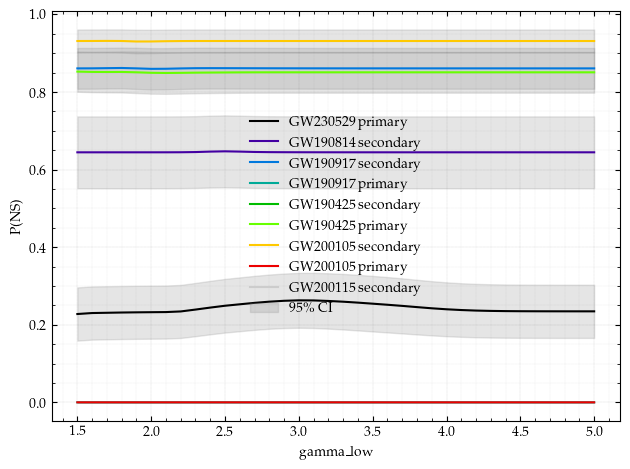

In [236]:
item = "gamma_low_non_parametric"
simple_grid_plot(results[item], folder2pop_parameter[item])

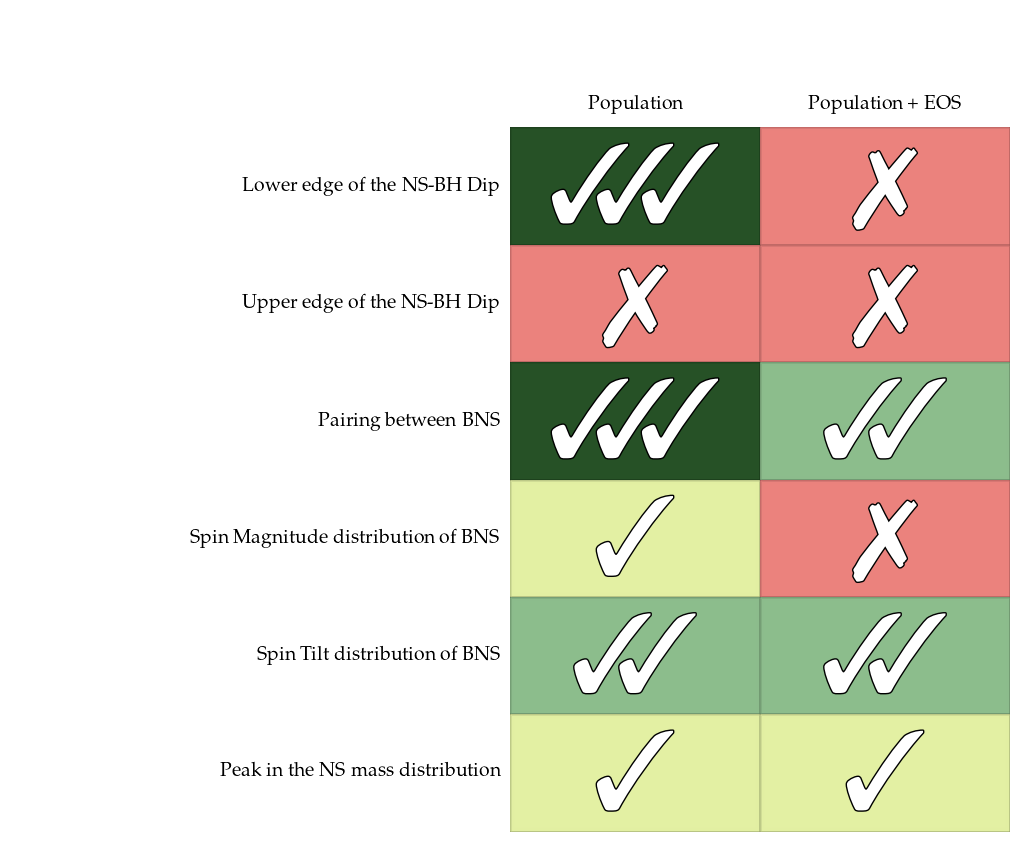

In [237]:
# Matrix grid: text + color box with tick/crosses, with title row and LaTeX/Unicode support
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.patheffects as patheffects
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

plt.rcParams['text.latex.preamble'] = r"\usepackage{amssymb, pifont, wasysym, xcolor}"


tick = r'\ding{51}'
cross = r'\ding{55}'

_gamma_low = "Lower edge of the NS-BH Dip"
_gamma_high = "Upper edge of the NS-BH Dip" 
# _beta_low =  
_beta_low_NS = "Pairing between BNS" 
_mu_sigma = "Spin Magnitude distribution of BNS"
_mu_costilt =  "Spin Tilt distribution of BNS"
# _sig_costilt =  
_mu_peak_NS = "Peak in the NS mass distribution"
# _sig_peak_NS = 
_amax = "Maximum value of NS Spin"

row_labels = [_gamma_low, _gamma_high, _beta_low_NS,_mu_sigma, _mu_costilt, _mu_peak_NS]

# 0: cross, 1: one tick, 2: two ticks, 3: three ticks
col_pop = [3, 0, 3, 1, 2, 1]
col_eos = [0, 0, 2, 0, 2, 1]

# Color and symbol logic
# 0: cross, red; 1: one tick, yellow; 2: two ticks, green; 3: three ticks, very dark green
color_map = {
    0: ("#EB827D", cross),           # red
    1: ("#E3F0A3", tick),           # yellow
    2: ("#8CBD8C", tick),           # green
    3: ("#265126", tick)            # very dark green
}

nrows = len(row_labels)
fig = plt.figure(figsize=(10, 1.2 * (nrows + 1)))
gs = gridspec.GridSpec(nrows + 1, 3, width_ratios=[2, 1, 1], wspace=0.0, hspace=0.0)  # wspace=0.0, hspace=0.0 for touching

TEXT_SIZE = 14
SIZE = 80
Y = 0.4
SPACING = 0.18
FONT = "Arial"

# Title row 
ax_title0 = fig.add_subplot(gs[0, 0])
# ax_title0.text(0.5, 0.5, "Feature", ha='center', va='center', fontsize=10, fontweight='bold')
ax_title0.axis('off')
ax_title1 = fig.add_subplot(gs[0, 1])
ax_title1.text(0.5, 0.2, "Population", ha='center', va='center', fontsize=TEXT_SIZE, fontweight='bold')
ax_title1.axis('off')
ax_title2 = fig.add_subplot(gs[0, 2])
ax_title2.text(0.5, 0.2, "Population + EOS", ha='center', va='center', fontsize=TEXT_SIZE, fontweight='bold')
ax_title2.axis('off')

# Data rows
for i, label in enumerate(row_labels):
    # First column: text 
    ax0 = fig.add_subplot(gs[i + 1, 0])
    ax0.text(0.98, 0.5, label, ha='right', va='center', fontsize=TEXT_SIZE)
    ax0.axis('off')
    # Second column: color box with ticks/cross 
    ax1 = fig.add_subplot(gs[i + 1, 1])
    color, symbol = color_map[col_pop[i]]
    rect1 = Rectangle((0, 0), 1, 1, color=color, alpha=0.85,
                      path_effects=[patheffects.withStroke(linewidth=6, foreground='black', alpha=0.3),
                                    patheffects.withStroke(linewidth=2, foreground='black', alpha=0.7)])
    ax1.add_patch(rect1)
    # Fuzzy black outline
    rect1_outline = Rectangle((0, 0), 1, 1, fill=False, linewidth=0.1, edgecolor='black',
                              path_effects=[patheffects.withStroke(linewidth=0.1, foreground='black', alpha=0.5)])
    ax1.add_patch(rect1_outline)
    if col_pop[i] == 0:
        ax1.text(0.5, Y, cross, ha='center', va='center', fontsize=SIZE, color='white', fontweight='bold', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'),patheffects.Normal()])
    else:
        for t in range(col_pop[i]):
            ax1.text(0.5 + (t-((col_pop[i]-1)/2))*SPACING, Y, tick, ha='center', va='center', fontsize=SIZE, color='white', fontweight='bold', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'),patheffects.Normal()])
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')
    # Third column: color box with ticks/cross 
    ax2 = fig.add_subplot(gs[i + 1, 2])
    color, symbol = color_map[col_eos[i]]
    rect2 = Rectangle((0, 0), 1, 1, color=color, alpha=0.85,
                      path_effects=[patheffects.withStroke(linewidth=6, foreground='black', alpha=0.3),
                                    patheffects.withStroke(linewidth=2, foreground='black', alpha=0.7)])
    ax2.add_patch(rect2)
    # Fuzzy black outline
    rect2_outline = Rectangle((0, 0), 1, 1, fill=False, linewidth=0.1, edgecolor='black',
                              path_effects=[patheffects.withStroke(linewidth=0.1, foreground='black', alpha=0.5)])
    ax2.add_patch(rect2_outline)
    if col_eos[i] == 0:
        ax2.text(0.5, Y, cross, ha='center', va='center', fontsize=SIZE, color='white', fontweight='bold', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'),patheffects.Normal()])
    else:
        for t in range(col_eos[i]):
            ax2.text(0.5+ (t-((col_eos[i]-1)/2))*SPACING, Y, tick, ha='center', va='center', fontsize=SIZE, color='white', fontweight='bold', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'),patheffects.Normal()])
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')

# Restore original 
plt.tight_layout(pad=0)
plt.savefig("plots/results_matrix.png", dpi = 300)
plt.show()

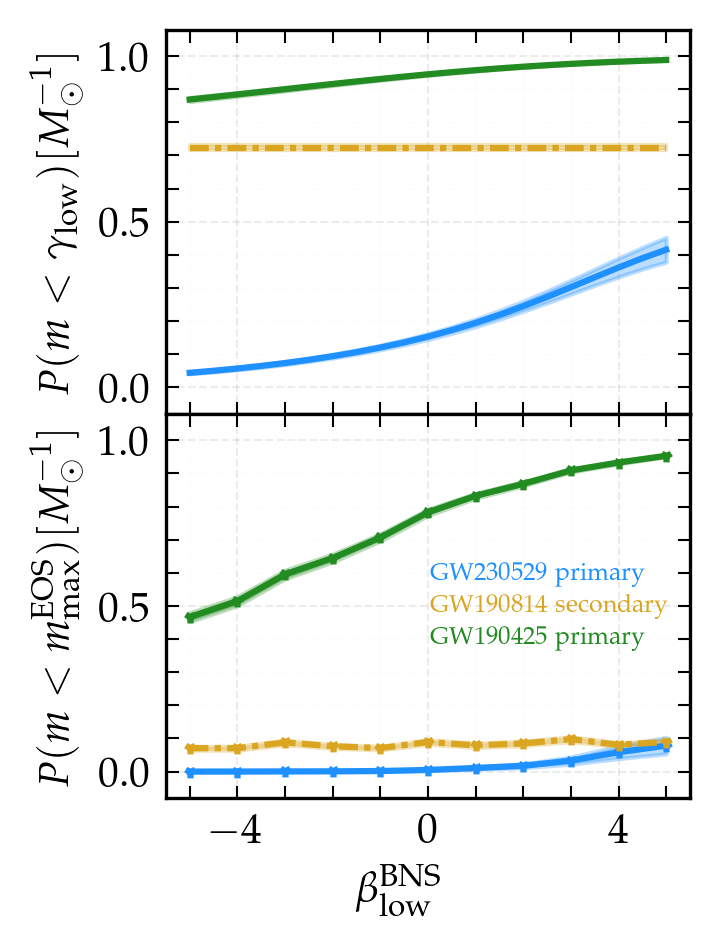

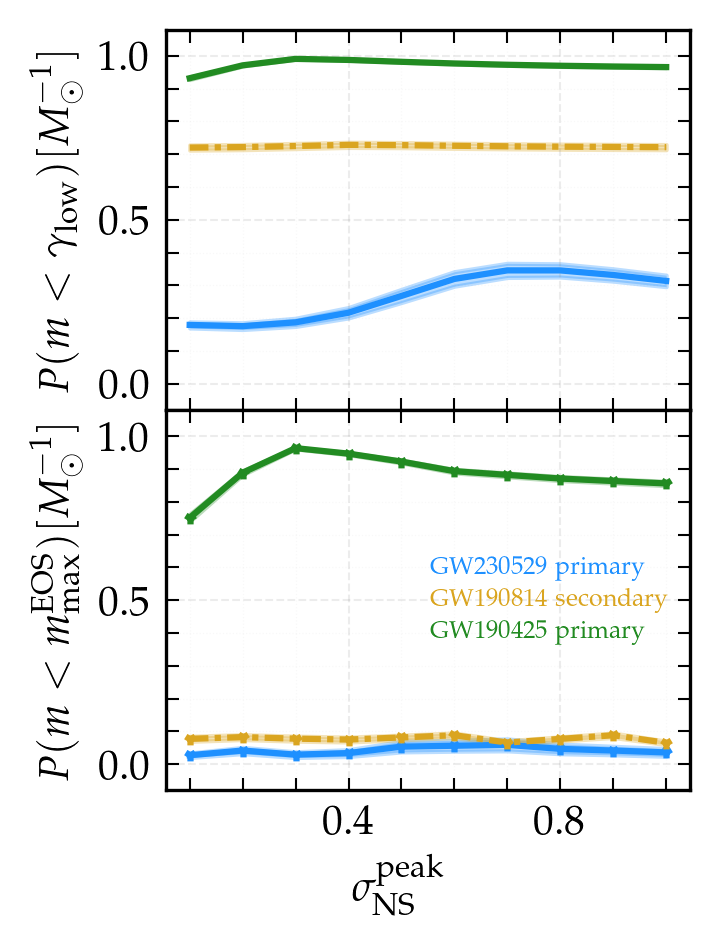

In [238]:
def key_to_name(tag):
    event, comp = tag.split("_")
    role = "primary" if comp == "1" else "secondary"
    return f"{event} {role}"

def name_to_key(name):
    # name example: "GW190917 primary"
    event = name.split()[0]
    comp = "1" if "primary" in name else "2"
    return f"{event}_{comp}"

def eos_pop_grid(df_pop, df_eos, pop_parameter, exclude_events = [], twocol_names = False):
    pop_GW190917_m1 = df_pop[(df_pop['event'] == "GW190917") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190917_m2 = df_pop[(df_pop['event'] == "GW190917") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW230529_m1 = df_pop[(df_pop['event'] == "GW230529") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190814_m2 = df_pop[(df_pop['event'] == "GW190814") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190425_m1 = df_pop[(df_pop['event'] == "GW190425") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190425_m2 = df_pop[(df_pop['event'] == "GW190425") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200105_m1 = df_pop[(df_pop['event'] == "GW200105") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200105_m2 = df_pop[(df_pop['event'] == "GW200105") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200115_m2 = df_pop[(df_pop['event'] == "GW200115") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_objects_lst = [pop_GW230529_m1, pop_GW190814_m2, pop_GW190917_m2, pop_GW190917_m1, pop_GW190425_m2, pop_GW190425_m1, pop_GW200105_m2, pop_GW200105_m1, pop_GW200115_m2]
    pop_objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    pop_objects_colors = [event_component_colors[name_to_key(name)] for name in pop_objects_names]

    eos_GW190917_m1 = df_eos[(df_eos['event'] == "GW190917") & (df_eos['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW190917_m2 = df_eos[(df_eos['event'] == "GW190917") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW230529_m1 = df_eos[(df_eos['event'] == "GW230529") & (df_eos['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW190814_m2 = df_eos[(df_eos['event'] == "GW190814") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW190425_m1 = df_eos[(df_eos['event'] == "GW190425") & (df_eos['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW190425_m2 = df_eos[(df_eos['event'] == "GW190425") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW200105_m1 = df_eos[(df_eos['event'] == "GW200105") & (df_eos['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW200105_m2 = df_eos[(df_eos['event'] == "GW200105") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW200115_m2 = df_eos[(df_eos['event'] == "GW200115") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_objects_lst = [eos_GW230529_m1, eos_GW190814_m2, eos_GW190917_m2, eos_GW190917_m1, eos_GW190425_m2, eos_GW190425_m1, eos_GW200105_m2, eos_GW200105_m1, eos_GW200115_m2]
    eos_objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    eos_objects_colors = [event_component_colors[name_to_key(name)] for name in eos_objects_names]


    exclude_labels = set(key_to_name(e) for e in exclude_events)
    # === Filter population lists
    pop_keep_idxs = [i for i, name in enumerate(pop_objects_names) if name not in exclude_labels]
    pop_objects_lst = [pop_objects_lst[i] for i in pop_keep_idxs]
    pop_objects_names = [pop_objects_names[i] for i in pop_keep_idxs]
    pop_is_primary = [s.split()[-1].lower() == 'primary' for s in pop_objects_names]
    pop_objects_colors = [pop_objects_colors[i] for i in pop_keep_idxs]

    # === Filter EOS lists
    eos_keep_idxs = [i for i, name in enumerate(eos_objects_names) if name not in exclude_labels]
    eos_objects_lst = [eos_objects_lst[i] for i in eos_keep_idxs]
    eos_objects_names = [eos_objects_names[i] for i in eos_keep_idxs]
    eos_objects_colors = [eos_objects_colors[i] for i in eos_keep_idxs]

    height = 3.375  # inches
    width = 2.5  
    FONTSIZE = 10

    fig = plt.figure(figsize=(width, height), dpi=300)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0)

    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])

    # === Plot population objects ===
    for i, curr in enumerate(pop_objects_lst):
        curr_name = pop_objects_names[i]
        is_primary = pop_is_primary[i]
        p05 = curr["probability"] - 1.28 * curr["prob_error"]
        p95 = curr["probability"] + 1.28 * curr["prob_error"]
        lab = "95\% CI" if i == len(pop_objects_lst) - 1 else None

        if is_primary:
            linestyle = "solid"
        else:
            linestyle = (0, (3, 1, 1, 1))

        ax0.plot(curr[pop_parameter], curr["probability"], label=curr_name, color=pop_objects_colors[i], linestyle=linestyle)
        ax0.fill_between(curr[pop_parameter], p05, p95, color=pop_objects_colors[i], alpha=0.3, label=lab)

    # === Plot EOS objects ===
    for i, curr in enumerate(eos_objects_lst):
        curr_name = eos_objects_names[i]
        is_primary = pop_is_primary[i]
        p05 = curr["probability"] - 1.28 * curr["prob_error"]
        p95 = curr["probability"] + 1.28 * curr["prob_error"]
        lab = "95\% CI" if i == len(eos_objects_lst) - 1 else None
        
        if is_primary:
            linestyle = "solid"
        else:
            linestyle = (0, (3, 1, 1, 1))

        ax1.plot(curr[pop_parameter], curr["probability"], label=curr_name, color=eos_objects_colors[i], linestyle=linestyle)
        ax1.scatter(curr[pop_parameter], curr["probability"], color=eos_objects_colors[i], s=8, zorder=3, marker = "1")
        ax1.fill_between(curr[pop_parameter], p05, p95, color=eos_objects_colors[i], alpha=0.3, label=lab)

    # === Share y-axis ===
    ax1.sharey(ax0)

    # === Format axes ===
    for ax in [ax0, ax1]:
        ax.tick_params(
            direction='in',       # Ticks inward
            top=True,             # Show top ticks
            right=True,           # Show right ticks
            which='both',         # Major and minor ticks
            length=3, width=0.5
        )

    for ax in [ax0, ax1]:
        ax.minorticks_on()
        ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.15)
        ax.grid(which='minor', axis='both', color='gray', linestyle=':', linewidth=0.3, alpha=0.05)

    # Remove y-axis labels and ticks on right plot
    # ax1.tick_params(labelleft=False)
    # ax1.set_ylabel("")
    

    # Shared x and y labels
    if pop_parameter in pop_parameter2latex:
        pop_lab = rf'{pop_parameter2latex[pop_parameter]}' 
    else:
        pop_lab = f"{pop_parameter}"

    fig.supxlabel(pop_lab, y=0.08, x = 0.55, fontsize=FONTSIZE)
    ax0.set_ylabel(r'$P(m < \gamma_{\mathrm{low}}) [M^{-1}_{\odot}]$', fontsize=FONTSIZE)
    ax1.set_ylabel(r'$P(m < m_{\rm max}^{\rm EOS}) [M^{-1}_{\odot}]$', fontsize=FONTSIZE)

    # ax1.legend()
    legend_elements_eos = [
    Line2D([0], [0], label=label, color='none')
    for label in eos_objects_names
    ]

    if twocol_names:
        legend = ax1.legend(handles=legend_elements_eos, loc='center right', fontsize=6, frameon=False, labelspacing=0.3, 
                            ncol=2, columnspacing=-2.5)
    else:
        legend = ax1.legend(handles=legend_elements_eos, loc='center right', fontsize=6, frameon=False, labelspacing=0.3)
    for text, color in zip(legend.get_texts(), eos_objects_colors):
        text.set_color(color)

    ax0.set_ylim(-0.08, 1.08)
    ax1.set_ylim(-0.08, 1.08)

    # Adjust layout to accommodate supxlabel
    plt.tight_layout()  # leave room for xlabel

item = "beta_low_NS"
exclude_events = ["GW200105_1", "GW200105_2", "GW200115_2", "GW190425_2", "GW190917_1", "GW190917_2"]
# exclude_events=[]
eos_pop_grid(results[item],results[item+"_EOS"], folder2pop_parameter[item], exclude_events=exclude_events)
plt.savefig(f"plots/pop_grid_eos_{item}.png", dpi = 300)

item = "sig_peak_NS"
exclude_events = ["GW200105_1", "GW200105_2", "GW200115_2", "GW190425_2", "GW190917_1", "GW190917_2"]
# exclude_events=[]
eos_pop_grid(results[item],results[item+"_EOS"], folder2pop_parameter[item], exclude_events=exclude_events)
plt.savefig(f"plots/pop_grid_eos_{item}.png", dpi = 300)

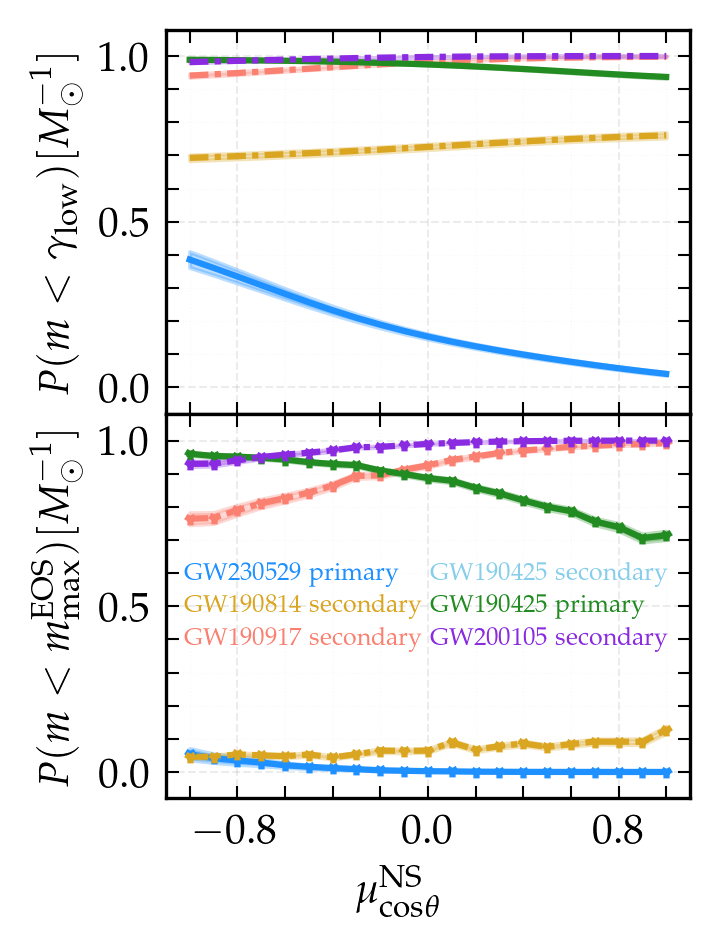

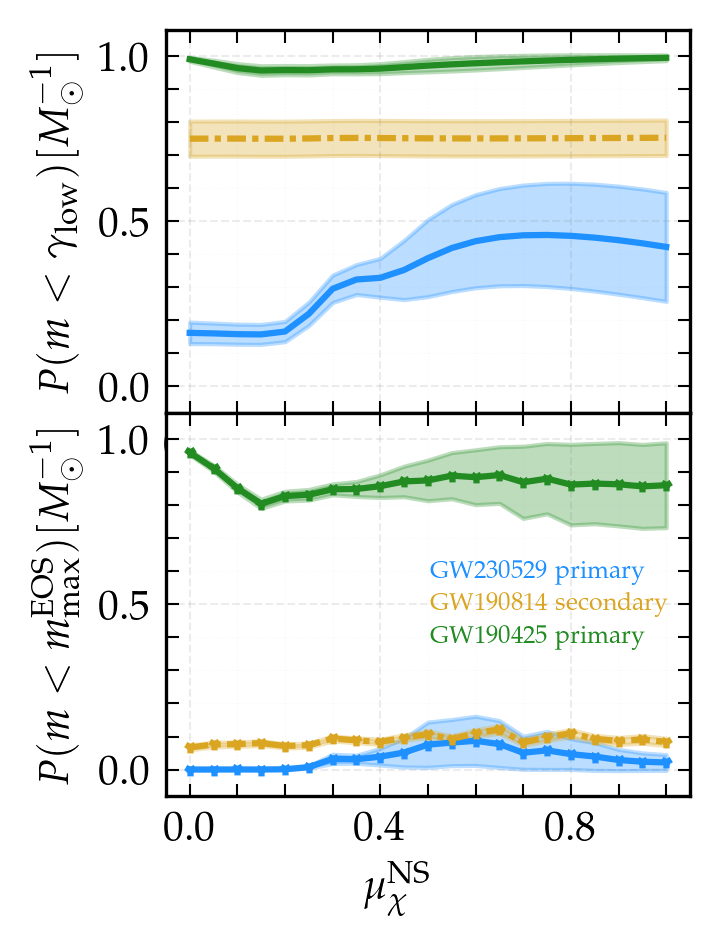

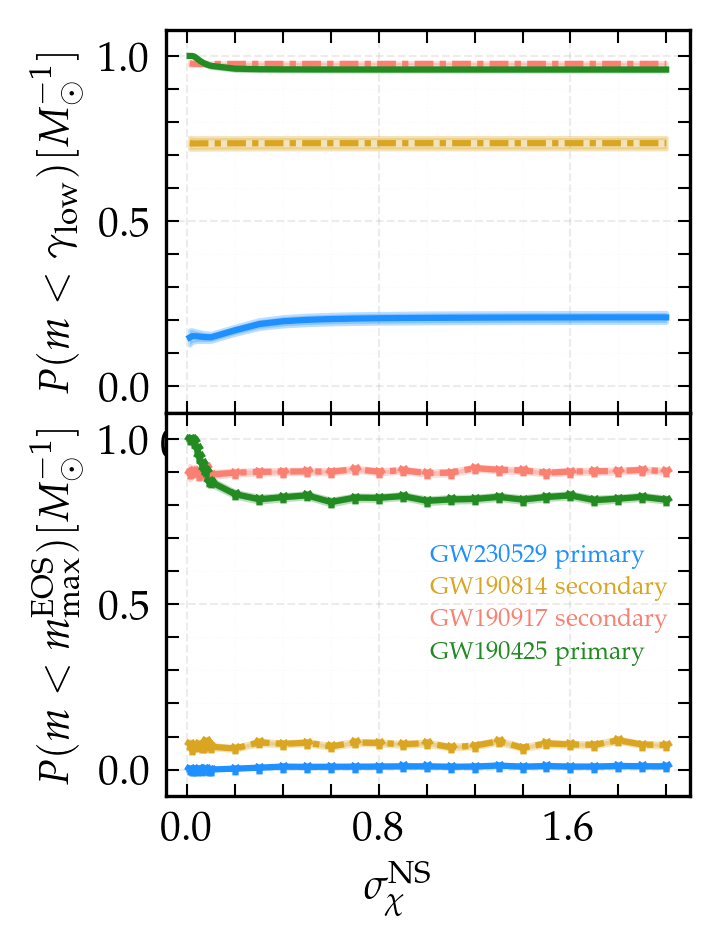

In [239]:
item = "mu_cos_tilt"
exclude_events = ["GW200105_1", "GW190917_1", "GW200115_2"]
# exclude_events=[]
eos_pop_grid(results[item],results[item+"_EOS"], folder2pop_parameter[item], exclude_events=exclude_events, twocol_names = True)
plt.savefig(f"plots/pop_grid_eos_{item}.png", dpi = 300)

item = "mu_chi1"
exclude_events = ["GW200105_1", "GW200105_2", "GW200115_2", "GW190425_2", "GW190917_1", "GW190917_2"]
# exclude_events=[]
eos_pop_grid(results[item],results[item+"_EOS"], folder2pop_parameter[item], exclude_events=exclude_events)
plt.savefig(f"plots/pop_grid_eos_{item}.png", dpi = 300)

item = "sigma_chi"
exclude_events = ["GW200105_1", "GW200105_2", "GW200115_2", "GW190425_2", "GW190917_1"]
# exclude_events=[]
eos_pop_grid(results[item],results[item+"_EOS"], folder2pop_parameter[item], exclude_events=exclude_events)
plt.savefig(f"plots/pop_grid_eos_{item}.png", dpi = 300)

In [240]:
from matplotlib.ticker import FormatStrFormatter
sys.path.append("../../")
from sampler.models.mass.mass_1d.pdb_with_NG import pdb_with_NG
from sampler.models.mass.pairing_functions.beta_split_3 import beta_split_3

alpha_1 = -3.99
alpha_2 = -0.30
gamma_low = 2.99
m_break = 6.50
eta_low = 24.84
gamma_high = 6.04
eta_high = 25.06
A = 0.14
m_min = 1.10
eta_min = 30.51
m_max = 70.95
eta_max = 4.48
mu_peak1 = 9.28
sig_peak1 = 1.60
peak_constant1 = 267.79
mu_peak2 = 29.33
sig_peak2 = 9.75
peak_constant2 = 215.33


mu_peak_NS = 1.4
sig_peak_NS = 0.1
peak_constant_NS = 0

gamma_low2 = 45
gamma_high2 = 80
eta_low2 = 100
eta_high2 = 100
A2 = 0
model_min = 1
model_max = 140

beta_1 = 1.29 # 2.31
beta_2 = 2.27 # 1.20
beta_gap = 1.04 # 1.10
sep = 5

mass_func = lambda m: pdb_with_NG(m, m_break, alpha_1, alpha_2,
                gamma_low, eta_low, gamma_high, eta_high, A, m_min, eta_min, m_max, eta_max,
                mu_peak1, sig_peak1, peak_constant1,
                mu_peak2, sig_peak2, peak_constant2,
                mu_peak_NS, sig_peak_NS, peak_constant_NS,
                model_min, model_max)



In [292]:
# import subprocess
# from pathlib import Path
#
# def pptx_to_png_with_libreoffice(pptx_path: str, out_dir: str):
#     pptx = Path(pptx_path).resolve()
#     out = Path(out_dir).resolve()
#     out.mkdir(parents=True, exist_ok=True)
#
#     subprocess.run([
#         "soffice", "--headless", "--invisible",
#         "--convert-to", "png",
#         "--outdir", str(out),
#         str(pptx)
#     ], check=True)
#
# # usage
# pptx_to_png_with_libreoffice("cartoons1.pptx", "plots/cartoons1")
# pptx_to_png_with_libreoffice("cartoons2.pptx", "plots/cartoons2")

convert /Users/utkarsh/GitHub/P_NS/mmms_analysis/paper_plots/cartoons1.pptx as a Impress document -> /Users/utkarsh/GitHub/P_NS/mmms_analysis/paper_plots/plots/cartoons1/cartoons1.png using filter : impress_png_Export
Overwriting: /Users/utkarsh/GitHub/P_NS/mmms_analysis/paper_plots/plots/cartoons1/cartoons1.png
convert /Users/utkarsh/GitHub/P_NS/mmms_analysis/paper_plots/cartoons2.pptx as a Impress document -> /Users/utkarsh/GitHub/P_NS/mmms_analysis/paper_plots/plots/cartoons2/cartoons2.png using filter : impress_png_Export
Overwriting: /Users/utkarsh/GitHub/P_NS/mmms_analysis/paper_plots/plots/cartoons2/cartoons2.png


/var/folders/hr/fxn20ncj0qq2_mtm8k66bl7r0000gn/T/ipykernel_99728/3980592772.py:325: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


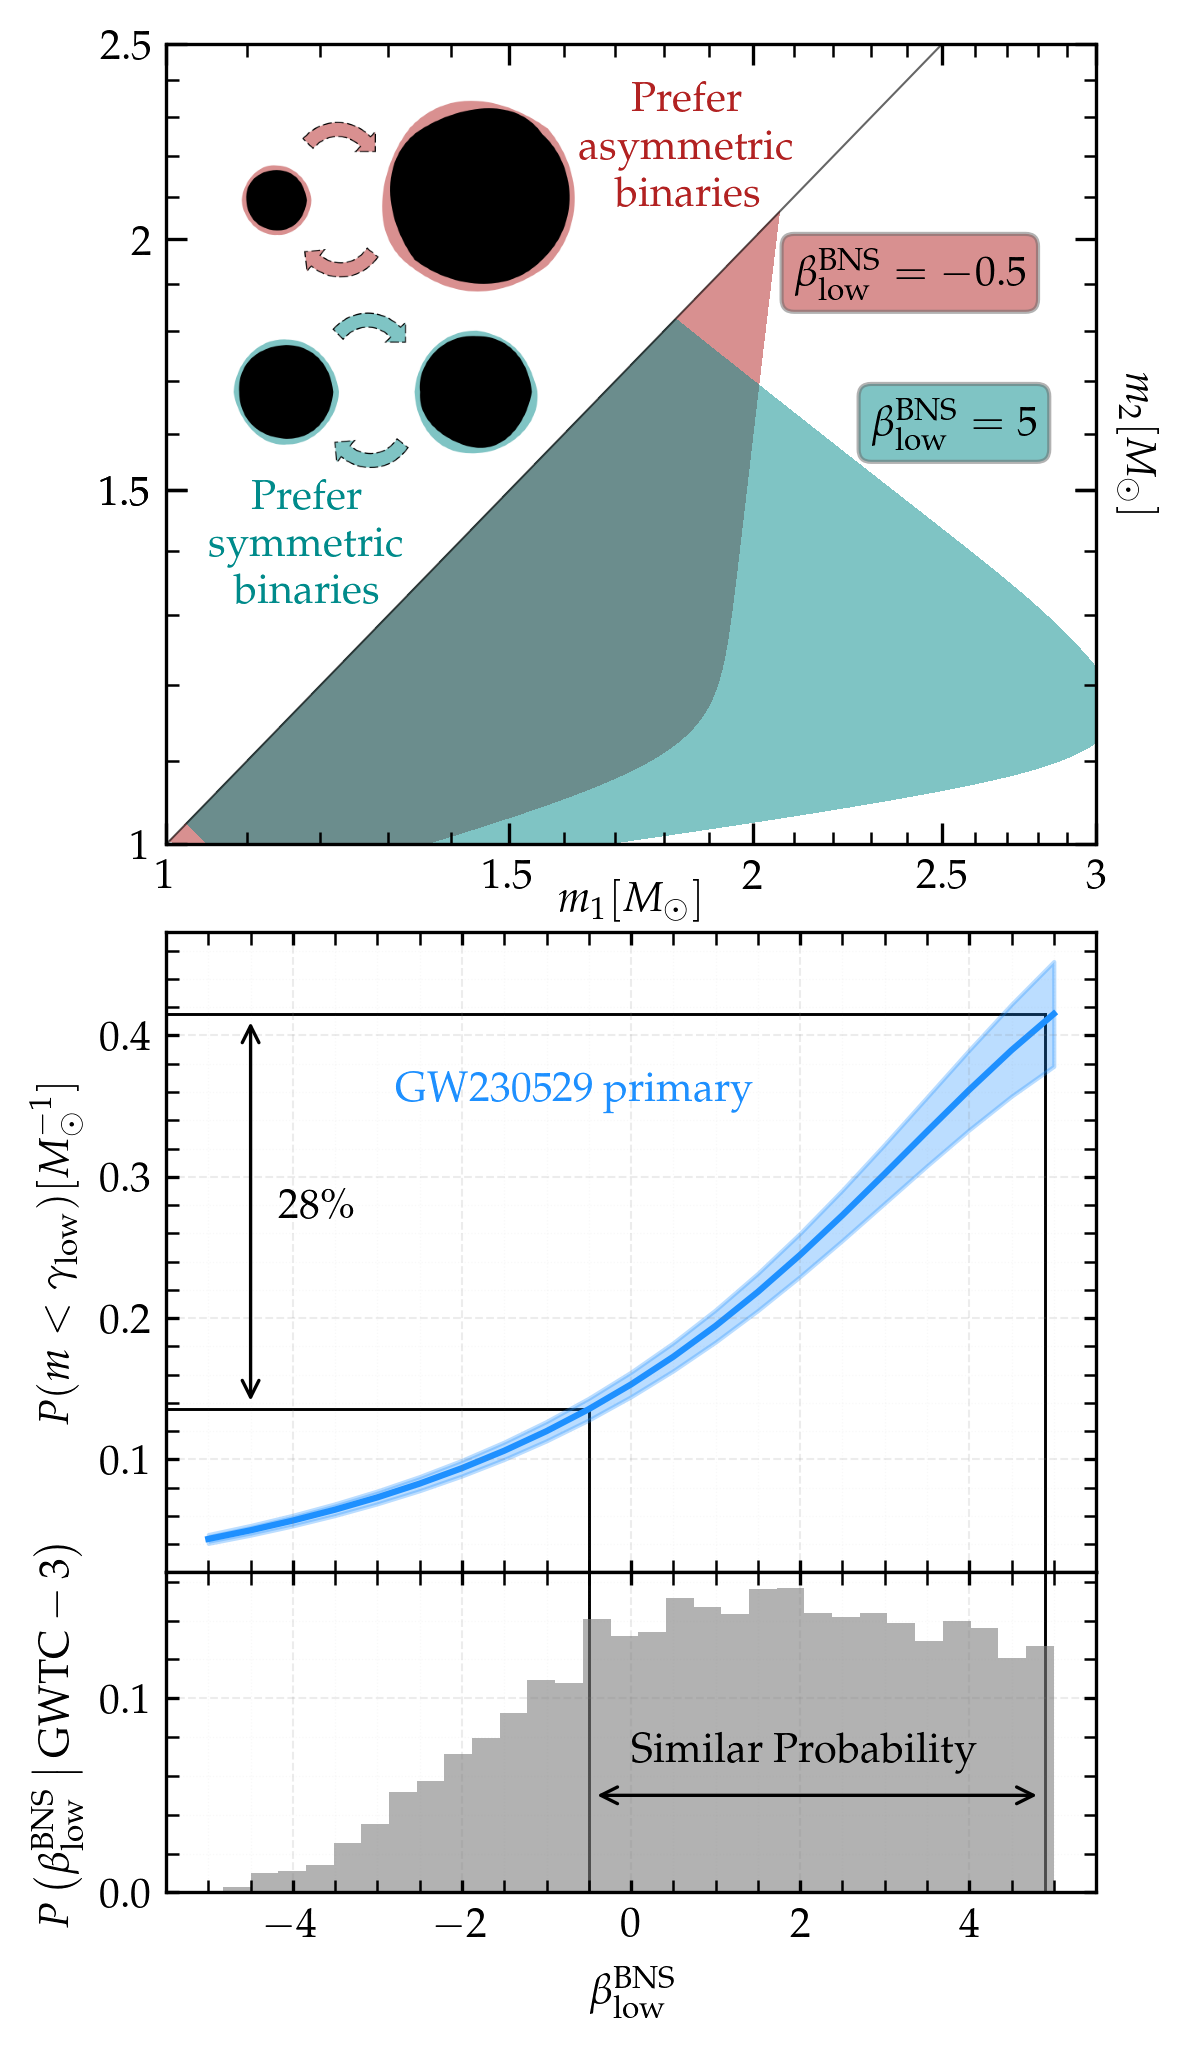

In [336]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_compare_hyperposterior_prob_NS_extra(df_pop, pop_parameter, exclude_events = []):
    pop_GW190917_m1 = df_pop[(df_pop['event'] == "GW190917") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190917_m2 = df_pop[(df_pop['event'] == "GW190917") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW230529_m1 = df_pop[(df_pop['event'] == "GW230529") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190814_m2 = df_pop[(df_pop['event'] == "GW190814") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190425_m1 = df_pop[(df_pop['event'] == "GW190425") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190425_m2 = df_pop[(df_pop['event'] == "GW190425") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200105_m1 = df_pop[(df_pop['event'] == "GW200105") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200105_m2 = df_pop[(df_pop['event'] == "GW200105") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200115_m2 = df_pop[(df_pop['event'] == "GW200115") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_objects_lst = [pop_GW230529_m1, pop_GW190814_m2, pop_GW190917_m2, pop_GW190917_m1, pop_GW190425_m2, pop_GW190425_m1, pop_GW200105_m2, pop_GW200105_m1, pop_GW200115_m2]
    pop_objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    pop_objects_colors = [event_component_colors[name_to_key(name)] for name in pop_objects_names]
    
    exclude_labels = set(key_to_name(e) for e in exclude_events)
    
    pop_keep_idxs = [i for i, name in enumerate(pop_objects_names) if name not in exclude_labels]
    pop_objects_lst = [pop_objects_lst[i] for i in pop_keep_idxs]
    pop_objects_names = [pop_objects_names[i] for i in pop_keep_idxs]
    pop_objects_colors = [pop_objects_colors[i] for i in pop_keep_idxs]

    run = "multiPDB_betaSplit3_brokenG" 
    filename = f"../conversion_scripts/{run}/population.csv.gz"
    population_run_df = pd.read_csv(filename, compression='gzip')
    samples = population_run_df.to_dict(orient="list")

    with open(f"../conversion_scripts/{run}/conversion_dict_inv.json", 'r') as f:
        conv_dict = json.load(f)

    parameter = conv_dict[pop_parameter]
    param_samples = samples[conv_dict[pop_parameter]]

    TEXT_SIZE = 10
    fig = plt.figure(figsize=(4, 8), dpi=300)

    outer = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2.5, 3.0], hspace=0.1)  # gap between plot 0 and 1
    ax  = fig.add_subplot(outer[0])

    inner = outer[1].subgridspec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.0)   # no gap between plots 1 and 2
    ax0 = fig.add_subplot(inner[0])
    ax1 = fig.add_subplot(inner[1], sharex=ax0)

    # Plot each object
    for i, curr in enumerate(pop_objects_lst):
        color = pop_objects_colors[i]
        name = pop_objects_names[i]
        p05 = curr["probability"] - 1.28 * curr["prob_error"]
        p95 = curr["probability"] + 1.28 * curr["prob_error"]
        
        ax0.plot(curr[pop_parameter], curr["probability"], color=color, zorder=0)
        ax0.fill_between(curr[pop_parameter], p05, p95, color=color, alpha=0.3, zorder=0)

    legend_elements_pop = [
    Line2D([0], [0], label=label, color='none')
    for label in pop_objects_names
    ]
    legend = ax0.legend(handles=legend_elements_pop, loc='center left', fontsize=TEXT_SIZE, bbox_to_anchor=(0.08, 0.75), frameon=False)
    for text, color in zip(legend.get_texts(), pop_objects_colors):
        text.set_color(color)

    # Axis styling
    lab = r"$P(m < \gamma_{\mathrm{low}}) [M^{-1}_{\odot}]$"
    ax0.set_ylabel(lab, fontsize=TEXT_SIZE)
    # ax0.tick_params(axis='both', direction='in', which='both', top=True, right=True, length=3)
    # ax0.yaxis.set_major_locator(plt.MaxNLocator(nbins=6, prune=None))


    for axs in [ax0, ax1]:
        axs.minorticks_on()
        axs.xaxis.set_major_locator(MaxNLocator(nbins=6))
        axs.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.15)
        axs.grid(which='minor', axis='both', color='gray', linestyle=':', linewidth=0.3, alpha=0.05)

    # Histogram below
    ax1.hist(param_samples, bins=30, density=True, color="grey", alpha = 0.6)  # More bins for detail


    #########
    x1 = 4.9
    y1_data = pop_GW230529_m1["probability"].iloc[np.argmin(np.abs(pop_GW230529_m1[pop_parameter].values - x1))]
    ymin, ymax = ax0.get_ylim() ; xmin, xmax = ax0.get_xlim()
    y1_frac = (y1_data - ymin) / (ymax - ymin) ; x1_frac = (x1 - xmin) / (xmax - xmin)
    ax0.axvline(x=x1, ymax=y1_frac, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    ax0.axhline(y=y1_data, xmax=x1_frac, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    ax1.axvline(x=x1, color='black', linestyle='-', linewidth=0.7, zorder=-1)

    x0 = -0.5
    y0_data = pop_GW230529_m1["probability"].iloc[np.argmin(np.abs(pop_GW230529_m1[pop_parameter].values - x0))]
    ymin, ymax = ax0.get_ylim() ; xmin, xmax = ax0.get_xlim()
    y0_frac = (y0_data - ymin) / (ymax - ymin) ; x0_frac = (x0 - xmin) / (xmax - xmin)
    ax0.axvline(x=x0, ymax=y0_frac, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    ax0.axhline(y=y0_data, xmax=x0_frac, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    ax1.axvline(x=x0, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    #########

    # X label with LaTeX if available
    if pop_parameter in pop_parameter2latex:
        pop_lab = rf'{pop_parameter2latex[pop_parameter]}' 
    else:
        pop_lab = f"{pop_parameter}"



    ax1.set_xlabel(pop_lab, fontsize=TEXT_SIZE)
    # ax1.set_ylabel(f"P({pop_lab}"r"$\mid$GWTC-3.0)", fontsize=TEXT_SIZE)
    pop_lab_math = pop_lab.strip("$")  # e.g. "$\\beta_{\\mathrm{low}}^\\mathrm{NS}$" -> "\beta_{\mathrm{low}}^\mathrm{NS}"
    ax1.set_ylabel(
        rf"$P\left({pop_lab_math}\,\middle|\,\mathrm{{GWTC}}-3\right)$",
        fontsize=TEXT_SIZE
    )

    for axs in [ax0, ax1]:
        axs .tick_params(axis='both', direction='in', which='both', top=True, right=True, length=3)


    x_left = x0
    x_right = x1
    y_arrow = 0.05      # vertical position of arrow in data coords; adjust to stay low

    ax1.annotate(
        '',
        xy=(x_right, y_arrow),
        xytext=(x_left, y_arrow),
        arrowprops=dict(arrowstyle='<->', color='black', linewidth=0.8),
        annotation_clip=False
    )

    # Vertical arrow spanning some range on ax0
    y_bot = y0_data   # start of arrow (lower end)
    y_top = y1_data   # end of arrow (upper end)
    x_arrow = x0 - 4     # slight offset so it doesn't lie directly on the vertical line

    ax0.annotate(
        '',
        xy=(x_arrow, y_top),
        xytext=(x_arrow, y_bot),
        arrowprops=dict(arrowstyle='<->', color='black', linewidth=0.8),
        annotation_clip=False
    )

    ax0.text(
        0.12, 0.60,  # x, y in axes fraction (0 to 1)
        f"~ {100*abs(y0_data-y1_data):.0f}\%",
        transform=ax0.transAxes,
        fontsize=TEXT_SIZE,
        verticalalignment='top',
        horizontalalignment='left'
    )

    ax1.text(
    0.5, 0.5,  # x, y in axes fraction (0 to 1)
    "Similar Probability",
    transform=ax1.transAxes,
    fontsize=TEXT_SIZE,
    verticalalignment='top',
    horizontalalignment='left'
    )

    ca = "firebrick"
    cs = "darkcyan"

    m = np.logspace(np.log10(0.9), np.log10(10), 1000)
    pairing_func = beta_split_3
    m1, m2 = np.meshgrid(m, m)

    beta_1 = 5
    beta_1_alt = -0.5

    pairing_function_args = (beta_1, beta_2, beta_gap, sep)
    f = pairing_func(m1, m2, *pairing_function_args)
    mat = np.where(m2 > m1, 0.0, (mass_func(m1) * mass_func(m2) * f))
    p_joint = mat / np.sum(mat)
    Z = np.ma.masked_less_equal(p_joint, 0.0)

    pairing_function_args_alt = (beta_1_alt, beta_2, beta_gap, sep)
    f_alt = pairing_func(m2, m1, *pairing_function_args_alt)  # swap to mirror
    mat_alt = np.where(m2 < m1, 0.0, (mass_func(m2) * mass_func(m1) * f_alt))
    p_joint_alt = mat_alt / np.sum(mat_alt)
    Z_alt = np.ma.masked_less_equal(p_joint_alt, 0.0)

    Z_full = np.ma.where(m2 > m1, Z_alt, Z)
    lev_min = 5e-8
    lev_max = 2e-4

    # Make levels consistent with actual data range after masking
    vmin = max(lev_min, float(Z_full.min()))

    Z_full = np.where(Z_full < vmin, vmin*1.001, Z_full)

    vmax = min(lev_max, float(Z_full.max()))
    levs = np.geomspace(vmin, vmax, num=3, endpoint=True)

    # cnt = ax.contourf(m1, m2, Z_full, levels=levs, cmap="inferno", norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

    # Normalize posterior to make it a PDF
    Z_norm = Z / np.sum(Z)
    Z_norm_alt = Z_alt.T / np.sum(Z_alt)

    # Flatten and sort
    Z_sorted = np.sort(Z_norm.flatten())[::-1]
    cumsum = np.cumsum(Z_sorted)

    # Find threshold for 90% CI
    level = Z_sorted[cumsum <= 0.9][-1]

    cnt = ax.contourf(
        m1, m2, Z_norm,
        levels=[level, Z_norm.max()],
        colors=ca, alpha = 0.5)

    cnt = ax.contourf(
        m1, m2, Z_norm_alt,
        levels=[level, Z_norm_alt.max()],
        colors=cs, alpha = 0.5)



    # ax.contour(m1, m2, Z_norm, levels=[level], colors="red", linewidths=2)

    ax.plot([m.min(), m.max()], [m.min(), m.max()], lw=0.5, color="black", alpha=0.6)
    ax.set_xscale("log"); ax.set_yscale("log")

    ax.xaxis.set_label_position("bottom")
    ax.yaxis.set_label_position("right")
    # ax.xaxis.tick_top()

    ax.text(2.3, 1.6, rf"$\beta_{{\rm low}}^{{\mathrm{{BNS}}}} = {beta_1}$",
            color="black", fontsize=10, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor=cs, edgecolor="0.4", alpha=0.5))

    ax.text(2.1, 1.9, rf"$\beta_{{\rm low}}^{{\mathrm{{BNS}}}} = {beta_1_alt}$",
            color="black", fontsize=10, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor=ca, edgecolor="0.4", alpha=0.5))

    ax.tick_params(
        direction="in",
        which="both",
        top=True,
        right=True,
        bottom = True,
        color="black",
        labelcolor="black",
    )

    ax.set_xlabel(r"$m_1 [M_{\odot}]$", labelpad=-5)
    ax.set_ylabel(r"$m_2 [M_{\odot}]$",rotation=270, labelpad=15)

    zoom_param = 0.20

    img = mpl.image.imread("plots/cartoons1/cartoons1.png")
    h, w = img.shape[:2]
    crop_size_x = int(min(h, w) * 0.7)
    crop_size_y = int(min(h, w) * 0.36)
    y1 = h//2 - crop_size_y//2
    y2 = h//2 + crop_size_y//2
    x1 = w//2 - crop_size_x//2
    x2 = w//2 + crop_size_x//2
    img_cropped = img[y1:y2, x1:x2]
    imagebox = mpl.offsetbox.OffsetImage(img_cropped, zoom=zoom_param)
    ab = mpl.offsetbox.AnnotationBbox(imagebox, (1.3, 2.1), frameon=False, zorder=-1)
    ax.add_artist(ab)
    img2 = mpl.image.imread("plots/cartoons2/cartoons2.png")
    h2, w2 = img2.shape[:2]
    y1_2 = h2//2 - crop_size_y//2
    y2_2 = h2//2 + crop_size_y//2
    x1_2 = w2//2 - crop_size_x//2
    x2_2 = w2//2 + crop_size_x//2
    img2_cropped = img2[y1_2:y2_2, x1_2:x2_2]
    imagebox2 = mpl.offsetbox.OffsetImage(img2_cropped, zoom=zoom_param)
    ab2 = mpl.offsetbox.AnnotationBbox(imagebox2, (1.28, 1.68), frameon=False, zorder=-2)
    ax.add_artist(ab2)

    ax.text(
        1.85, 2.05,
        "Prefer\nasymmetric\nbinaries",
        ha="center", va="bottom",
        fontsize=10, color=ca,
        # bbox=dict(boxstyle="round,pad=0.3", facecolor="firebrick", alpha=0.5)
    )

    ax.text(
        1.18, 1.30,
        "Prefer\nsymmetric\nbinaries",
        ha="center", va="bottom",
        fontsize=10, color=cs,
        # bbox=dict(boxstyle="round,pad=0.3", facecolor="dodgerblue", alpha=0.5)
    )

    ax.set_xlim(1, 3)
    ax.set_ylim(1, 2.5)

    # Major ticks + labels
    xmaj = [1.0, 1.5, 2.0, 2.5, 3.0]
    ymaj = [1.0, 1.5, 1.5, 2.0, 2.5]

    ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(xmaj))
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(ymaj))
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v, p: f"{v:g}"))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda v, p: f"{v:g}"))

    # Minor ticks: keep marks, no labels
    # Put minors at 0.1 step between integers, but skip majors
    xmin = np.r_[np.arange(1.1, 2.0, 0.1), np.arange(2.1, 3.0, 0.1)]
    xmin = xmin[~np.isin(xmin, xmaj)]
    ymin = np.r_[np.arange(1.1, 2.0, 0.1), np.arange(2.1, 2.5, 0.1)]
    ymin = ymin[~np.isin(ymin, ymaj)]

    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(xmin))
    ax.yaxis.set_minor_locator(mpl.ticker.FixedLocator(ymin))
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    # (Optional) make minor tick marks a bit shorter/lighter
    ax.tick_params(axis="both", which="minor", length=3, width=0.6)
    ax.tick_params(axis="both", which="major", length=5, width=0.8)


    # Hide top ticks of lower plot
    plt.setp(ax0.get_xticklabels(), visible=False)

    # Adjust spacing and layout
    plt.subplots_adjust(hspace=0.00)
    plt.tight_layout()


item = "beta_low_NS"
exclude_events = ["GW200105_1", "GW200105_2", "GW200115_2", "GW190425_2", "GW190917_1", "GW190917_2", "GW190814_2", "GW190425_1"]
plot_compare_hyperposterior_prob_NS_extra(results[item], folder2pop_parameter[item], exclude_events=exclude_events)
plt.savefig("plots/hyperposterior_PNS_comparison_extra.png", dpi=300, bbox_inches='tight')

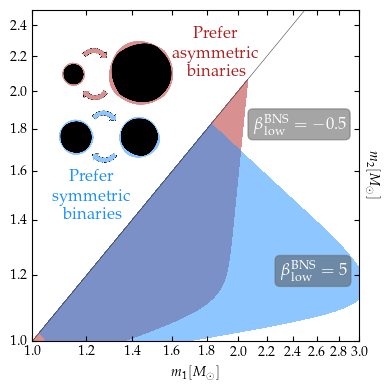

In [277]:
fig, ax = plt.subplots(figsize=(4,4))

m = np.logspace(np.log10(0.9), np.log10(10), 1000)
pairing_func = beta_split_3
m1, m2 = np.meshgrid(m, m)

beta_1 = 5
beta_1_alt = -0.5

pairing_function_args = (beta_1, beta_2, beta_gap, sep)
f = pairing_func(m1, m2, *pairing_function_args)
mat = np.where(m2 > m1, 0.0, (mass_func(m1) * mass_func(m2) * f))
p_joint = mat / np.sum(mat)
Z = np.ma.masked_less_equal(p_joint, 0.0)

pairing_function_args_alt = (beta_1_alt, beta_2, beta_gap, sep)
f_alt = pairing_func(m2, m1, *pairing_function_args_alt)  # swap to mirror
mat_alt = np.where(m2 < m1, 0.0, (mass_func(m2) * mass_func(m1) * f_alt))
p_joint_alt = mat_alt / np.sum(mat_alt)
Z_alt = np.ma.masked_less_equal(p_joint_alt, 0.0)

Z_full = np.ma.where(m2 > m1, Z_alt, Z)
lev_min = 5e-8
lev_max = 2e-4

# Make levels consistent with actual data range after masking
vmin = max(lev_min, float(Z_full.min()))

Z_full = np.where(Z_full < vmin, vmin*1.001, Z_full)

vmax = min(lev_max, float(Z_full.max()))
levs = np.geomspace(vmin, vmax, num=3, endpoint=True)

# cnt = ax.contourf(m1, m2, Z_full, levels=levs, cmap="inferno", norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

# Normalize posterior to make it a PDF
Z_norm = Z / np.sum(Z)
Z_norm_alt = Z_alt.T / np.sum(Z_alt)

# Flatten and sort
Z_sorted = np.sort(Z_norm.flatten())[::-1]
cumsum = np.cumsum(Z_sorted)

# Find threshold for 90% CI
level = Z_sorted[cumsum <= 0.9][-1]

cnt = ax.contourf(
    m1, m2, Z_norm,
    levels=[level, Z_norm.max()],
    colors="firebrick", alpha = 0.5)

cnt = ax.contourf(
    m1, m2, Z_norm_alt,
    levels=[level, Z_norm_alt.max()],
    colors="dodgerblue", alpha = 0.5)



# ax.contour(m1, m2, Z_norm, levels=[level], colors="red", linewidths=2)

ax.plot([m.min(), m.max()], [m.min(), m.max()], lw=0.5, color="black", alpha=0.6)
ax.set_xscale("log"); ax.set_yscale("log")

ax.xaxis.set_label_position("bottom")
ax.yaxis.set_label_position("right")
# ax.xaxis.tick_top()

ticks = np.arange(1.0, 4.6, 0.2)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

ax.text(2.3, 1.2, rf"$\beta_{{\rm low}}^{{\mathrm{{BNS}}}} = {beta_1}$",
        color="white", fontsize=12, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="0.3", edgecolor="0.4", alpha=0.5))

ax.text(2.1, 1.8, rf"$\beta_{{\rm low}}^{{\mathrm{{BNS}}}} = {beta_1_alt}$",
        color="white", fontsize=12, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="0.3", edgecolor="0.4", alpha=0.5))

ax.tick_params(
    direction="in",
    which="both",
    top=True,
    right=True,
    bottom = True,
    color="black",
    labelcolor="black",
)

ax.set_xlim(1, 3); ax.set_ylim(1, 2.5)
ax.set_xlabel(r"$m_1 [M_{\odot}]$")
ax.set_ylabel(r"$m_2 [M_{\odot}]$",rotation=270, labelpad=15)

zoom_param = 0.20

img = mpl.image.imread("plots/cartoons1/cartoons1.png")
h, w = img.shape[:2]
crop_size_x = int(min(h, w) * 0.7)
crop_size_y = int(min(h, w) * 0.36)
y1 = h//2 - crop_size_y//2
y2 = h//2 + crop_size_y//2
x1 = w//2 - crop_size_x//2
x2 = w//2 + crop_size_x//2
img_cropped = img[y1:y2, x1:x2]
imagebox = mpl.offsetbox.OffsetImage(img_cropped, zoom=zoom_param)
ab = mpl.offsetbox.AnnotationBbox(imagebox, (1.3, 2.1), frameon=False, zorder=-1)
ax.add_artist(ab)
img2 = mpl.image.imread("plots/cartoons2/cartoons2.png")
h2, w2 = img2.shape[:2]
y1_2 = h2//2 - crop_size_y//2
y2_2 = h2//2 + crop_size_y//2
x1_2 = w2//2 - crop_size_x//2
x2_2 = w2//2 + crop_size_x//2
img2_cropped = img2[y1_2:y2_2, x1_2:x2_2]
imagebox2 = mpl.offsetbox.OffsetImage(img2_cropped, zoom=zoom_param)
ab2 = mpl.offsetbox.AnnotationBbox(imagebox2, (1.28, 1.76), frameon=False, zorder=-2)
ax.add_artist(ab2)

ax.text(
    1.85, 2.05,
    "Prefer\nasymmetric\nbinaries",
    ha="center", va="bottom",
    fontsize=12, color="firebrick",
    # bbox=dict(boxstyle="round,pad=0.3", facecolor="firebrick", alpha=0.5)
)

ax.text(
    1.22, 1.38,
    "Prefer\nsymmetric\nbinaries",
    ha="center", va="bottom",
    fontsize=12, color="dodgerblue",
    # bbox=dict(boxstyle="round,pad=0.3", facecolor="dodgerblue", alpha=0.5)
)

plt.savefig("plots/pop_model_joint_zoom_alt.png", dpi=300)

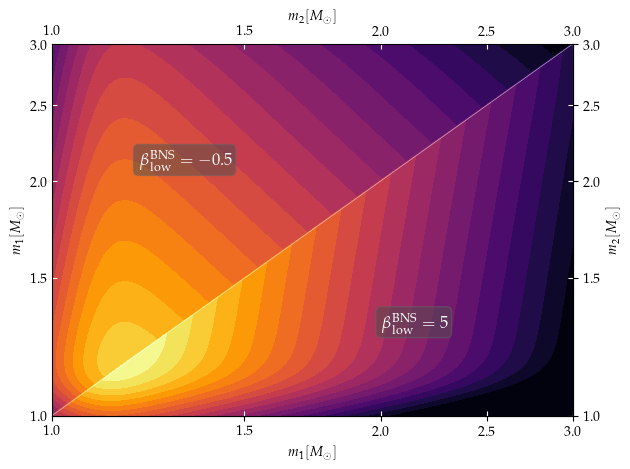

In [244]:
fig, ax = plt.subplots()

m = np.logspace(np.log10(0.9), np.log10(10), 1000)
pairing_func = beta_split_3
m1, m2 = np.meshgrid(m, m)

beta_1 = 5
beta_1_alt = -0.5

pairing_function_args = (beta_1, beta_2, beta_gap, sep)
f = pairing_func(m1, m2, *pairing_function_args)
mat = np.where(m2 > m1, 0.0, (mass_func(m1) * mass_func(m2) * f))
p_joint = mat / np.sum(mat)
Z = np.ma.masked_less_equal(p_joint, 0.0)

pairing_function_args_alt = (beta_1_alt, beta_2, beta_gap, sep)
f_alt = pairing_func(m2, m1, *pairing_function_args_alt)  # swap to mirror
mat_alt = np.where(m2 < m1, 0.0, (mass_func(m2) * mass_func(m1) * f_alt))
p_joint_alt = mat_alt / np.sum(mat_alt)
Z_alt = np.ma.masked_less_equal(p_joint_alt, 0.0)

Z_full = np.ma.where(m2 > m1, Z_alt, Z)
lev_min = 5e-8
lev_max = 2e-4

# Make levels consistent with actual data range after masking
vmin = max(lev_min, float(Z_full.min()))

Z_full = np.where(Z_full < vmin, vmin*1.001, Z_full)

vmax = min(lev_max, float(Z_full.max()))
levs = np.geomspace(vmin, vmax, num=21, endpoint=True)

cnt = ax.contourf(m1, m2, Z_full, levels=levs, cmap="inferno",
                norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

ax.plot([m.min(), m.max()], [m.min(), m.max()], lw=0.5, color="white", alpha=0.6)
ax.set_xscale("log"); ax.set_yscale("log")

ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()

ticks = np.arange(1.0, 4.6, 0.5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

ax.text(2.0, 1.3, rf"$\beta_{{\rm low}}^{{\mathrm{{BNS}}}} = {beta_1}$",
        color="white", fontsize=12, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="0.3", edgecolor="0.4", alpha=0.5))

ax.text(1.2, 2.1, rf"$\beta_{{\rm low}}^{{\mathrm{{BNS}}}} = {beta_1_alt}$",
        color="white", fontsize=12, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="0.3", edgecolor="0.4", alpha=0.5))

ax.tick_params(
    direction="in",
    which="both",
    top=True,
    right=True,
    bottom = True,
    color="white",
    labelcolor="black",
)

ax.set_xlim(1, 3); ax.set_ylim(1, 3)
ax.set_xlabel(r"$m_2 [M_{\odot}]$")
ax.set_ylabel(r"$m_1 [M_{\odot}]$")

# Make a twin x-axis on top and a twin y-axis on the right
ax_top = ax.secondary_xaxis("bottom")
ax_right = ax.secondary_yaxis("right")

# Example: rescale or reformat ticks differently
# (here I'll just shift and format them for demonstration)
ax_top.set_xlabel(r"$m_1 [M_{\odot}]$")
ax_top.set_xticks(ticks)
ax_top.set_xticklabels(ticks)

ax_right.set_ylabel(r"$m_2 [M_{\odot}]$")
ax_right.set_yticks(ticks)
ax_right.set_yticklabels(ticks)

plt.savefig("plots/pop_model_joint_zoom_v2.png", dpi=300)

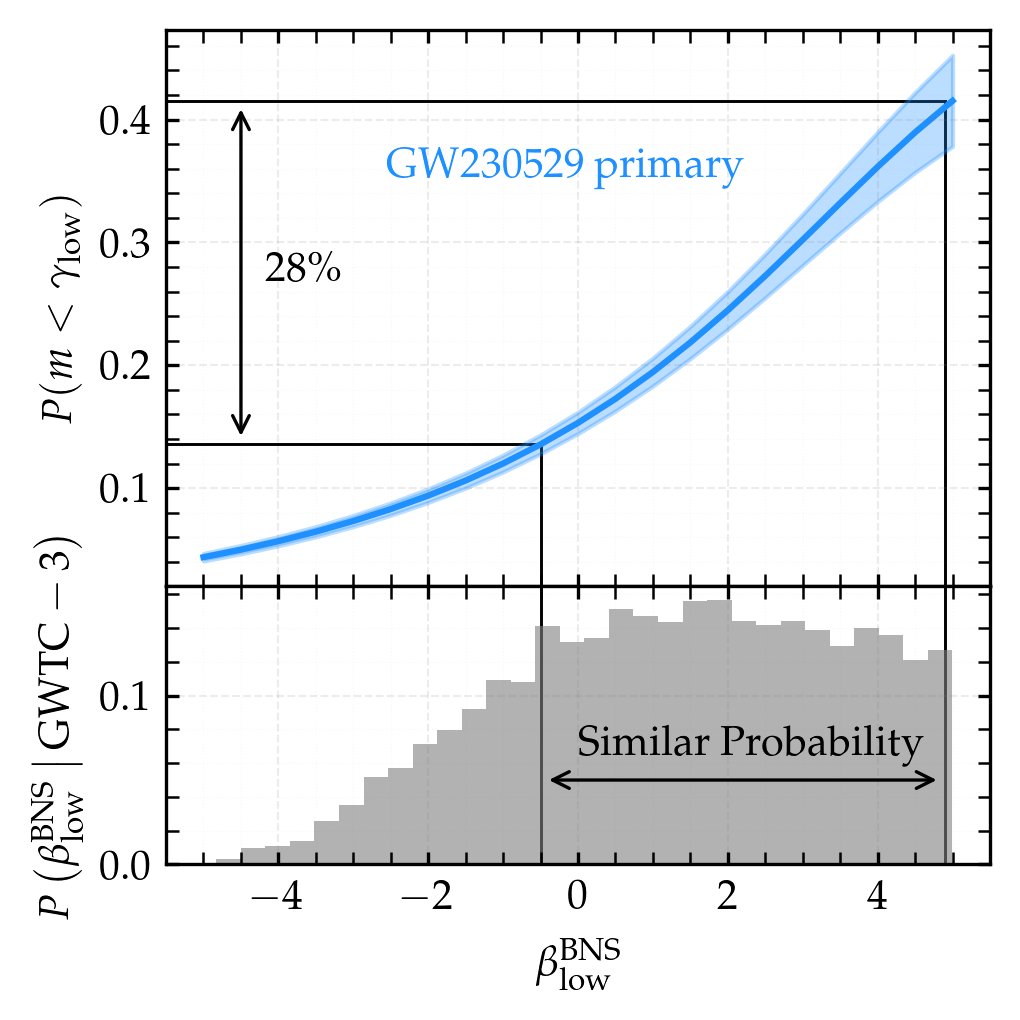

In [245]:
def plot_compare_hyperposterior_prob_NS(df_pop, pop_parameter, exclude_events = []):
    pop_GW190917_m1 = df_pop[(df_pop['event'] == "GW190917") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190917_m2 = df_pop[(df_pop['event'] == "GW190917") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW230529_m1 = df_pop[(df_pop['event'] == "GW230529") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190814_m2 = df_pop[(df_pop['event'] == "GW190814") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190425_m1 = df_pop[(df_pop['event'] == "GW190425") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190425_m2 = df_pop[(df_pop['event'] == "GW190425") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200105_m1 = df_pop[(df_pop['event'] == "GW200105") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200105_m2 = df_pop[(df_pop['event'] == "GW200105") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200115_m2 = df_pop[(df_pop['event'] == "GW200115") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_objects_lst = [pop_GW230529_m1, pop_GW190814_m2, pop_GW190917_m2, pop_GW190917_m1, pop_GW190425_m2, pop_GW190425_m1, pop_GW200105_m2, pop_GW200105_m1, pop_GW200115_m2]
    pop_objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    pop_objects_colors = [event_component_colors[name_to_key(name)] for name in pop_objects_names]
    
    exclude_labels = set(key_to_name(e) for e in exclude_events)
    
    pop_keep_idxs = [i for i, name in enumerate(pop_objects_names) if name not in exclude_labels]
    pop_objects_lst = [pop_objects_lst[i] for i in pop_keep_idxs]
    pop_objects_names = [pop_objects_names[i] for i in pop_keep_idxs]
    pop_objects_colors = [pop_objects_colors[i] for i in pop_keep_idxs]

    run = "multiPDB_betaSplit3_brokenG" 
    filename = f"../conversion_scripts/{run}/population.csv.gz"
    population_run_df = pd.read_csv(filename, compression='gzip')
    samples = population_run_df.to_dict(orient="list")

    with open(f"../conversion_scripts/{run}/conversion_dict_inv.json", 'r') as f:
        conv_dict = json.load(f)

    parameter = conv_dict[pop_parameter]
    param_samples = samples[conv_dict[pop_parameter]]

    # === Gridspec layout with shared x-axis ==
    TEXT_SIZE = 10
    fig = plt.figure(figsize=(3.5, 3.5), dpi=300)
    # Gridspec layout
    gs  = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.00)
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1], sharex=ax0)

    # Plot each object
    for i, curr in enumerate(pop_objects_lst):
        color = pop_objects_colors[i]
        name = pop_objects_names[i]
        p05 = curr["probability"] - 1.28 * curr["prob_error"]
        p95 = curr["probability"] + 1.28 * curr["prob_error"]
        
        ax0.plot(curr[pop_parameter], curr["probability"], color=color, zorder=0)
        ax0.fill_between(curr[pop_parameter], p05, p95, color=color, alpha=0.3, zorder=0)

    legend_elements_pop = [
    Line2D([0], [0], label=label, color='none')
    for label in pop_objects_names
    ]
    legend = ax0.legend(handles=legend_elements_pop, loc='center left', fontsize=TEXT_SIZE, bbox_to_anchor=(0.08, 0.75), frameon=False)
    for text, color in zip(legend.get_texts(), pop_objects_colors):
        text.set_color(color)

    # Axis styling
    lab = r"$P(m < \gamma_{\mathrm{low}})$"
    ax0.set_ylabel(lab, fontsize=TEXT_SIZE)
    # ax0.tick_params(axis='both', direction='in', which='both', top=True, right=True, length=3)
    # ax0.yaxis.set_major_locator(plt.MaxNLocator(nbins=6, prune=None))


    for ax in [ax0, ax1]:
        ax.minorticks_on()
        ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
        ax.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.15)
        ax.grid(which='minor', axis='both', color='gray', linestyle=':', linewidth=0.3, alpha=0.05)

    # Histogram below
    ax1.hist(param_samples, bins=30, density=True, color="grey", alpha = 0.6)  # More bins for detail


    #########
    # Choose x0 and y0: the target point on the top plot
    x1 = 4.9
    y1_data = pop_GW230529_m1["probability"].iloc[np.argmin(np.abs(pop_GW230529_m1[pop_parameter].values - x1))]
    ymin, ymax = ax0.get_ylim() ; xmin, xmax = ax0.get_xlim()
    y1_frac = (y1_data - ymin) / (ymax - ymin) ; x1_frac = (x1 - xmin) / (xmax - xmin)
    ax0.axvline(x=x1, ymax=y1_frac, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    ax0.axhline(y=y1_data, xmax=x1_frac, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    ax1.axvline(x=x1, color='black', linestyle='-', linewidth=0.7, zorder=-1)

    x0 = -0.5
    y0_data = pop_GW230529_m1["probability"].iloc[np.argmin(np.abs(pop_GW230529_m1[pop_parameter].values - x0))]
    ymin, ymax = ax0.get_ylim() ; xmin, xmax = ax0.get_xlim()
    y0_frac = (y0_data - ymin) / (ymax - ymin) ; x0_frac = (x0 - xmin) / (xmax - xmin)
    ax0.axvline(x=x0, ymax=y0_frac, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    ax0.axhline(y=y0_data, xmax=x0_frac, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    ax1.axvline(x=x0, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    #########

    # X label with LaTeX if available
    if pop_parameter in pop_parameter2latex:
        pop_lab = rf'{pop_parameter2latex[pop_parameter]}' 
    else:
        pop_lab = f"{pop_parameter}"



    ax1.set_xlabel(pop_lab, fontsize=TEXT_SIZE)
    # ax1.set_ylabel(f"P({pop_lab}"r"$\mid$GWTC-3.0)", fontsize=TEXT_SIZE)
    pop_lab_math = pop_lab.strip("$")  # e.g. "$\\beta_{\\mathrm{low}}^\\mathrm{NS}$" -> "\beta_{\mathrm{low}}^\mathrm{NS}"
    ax1.set_ylabel(
        rf"$P\left({pop_lab_math}\,\middle|\,\mathrm{{GWTC}}-3\right)$",
        fontsize=TEXT_SIZE
    )

    for ax in [ax0, ax1]:
        ax.tick_params(axis='both', direction='in', which='both', top=True, right=True, length=3)


    x_left = x0
    x_right = x1
    y_arrow = 0.05      # vertical position of arrow in data coords; adjust to stay low

    ax1.annotate(
        '',
        xy=(x_right, y_arrow),
        xytext=(x_left, y_arrow),
        arrowprops=dict(arrowstyle='<->', color='black', linewidth=0.8),
        annotation_clip=False
    )

    # Vertical arrow spanning some range on ax0
    y_bot = y0_data   # start of arrow (lower end)
    y_top = y1_data   # end of arrow (upper end)
    x_arrow = x0 - 4     # slight offset so it doesn't lie directly on the vertical line

    ax0.annotate(
        '',
        xy=(x_arrow, y_top),
        xytext=(x_arrow, y_bot),
        arrowprops=dict(arrowstyle='<->', color='black', linewidth=0.8),
        annotation_clip=False
    )

    ax0.text(
        0.12, 0.60,  # x, y in axes fraction (0 to 1)
        f"~ {100*abs(y0_data-y1_data):.0f}\%",
        transform=ax0.transAxes,
        fontsize=TEXT_SIZE,
        verticalalignment='top',
        horizontalalignment='left'
    )

    ax1.text(
    0.5, 0.5,  # x, y in axes fraction (0 to 1)
    "Similar Probability",
    transform=ax1.transAxes,
    fontsize=TEXT_SIZE,
    verticalalignment='top',
    horizontalalignment='left'
    )

    # Hide top ticks of lower plot
    plt.setp(ax0.get_xticklabels(), visible=False)

    # Adjust spacing and layout
    plt.subplots_adjust(hspace=0.00)
    plt.tight_layout()


item = "beta_low_NS"
exclude_events = ["GW200105_1", "GW200105_2", "GW200115_2", "GW190425_2", "GW190917_1", "GW190917_2", "GW190814_2", "GW190425_1"]
plot_compare_hyperposterior_prob_NS(results[item], folder2pop_parameter[item], exclude_events=exclude_events)
plt.savefig("plots/hyperposterior_PNS_comparison.png", dpi=300)

In [246]:
from conversion_cosmology import Cosmology
import sys
import json
import pandas as pd
from matplotlib.lines import Line2D

try:
    sys.path.insert(0, "../../sampler/runs/multiPDB_betaSplit3_brokenG_1_full/")
    from model_vector import model_vector
except:
    sys.path.append("../../sampler/runs/multiPDB_betaSplit3_brokenG_1_full/")
    from sampler.runs.multiPDB_betaSplit3_brokenG_1_full.model_vector import model_vector 

path = "../conversion_scripts/multiPDB_betaSplit3_brokenG/conversion_dict_inv.json"

with open(path, "r") as f:
    conv = json.load(f)

conv["w"] = "w"
PLANCK_2018_Ho = 2.1816926176539463e-18 ### CGS
PLANCK_2018_OmegaMatter = 0.3158
PLANCK_2018_OmegaLambda = 1. - PLANCK_2018_OmegaMatter
PLANCK_2018_OmegaRadiation = 0.

### define units in SI
C_SI =  299792458.0
PC_SI = 3.085677581491367e+16
MPC_SI = PC_SI * 1e6
G_SI = 6.6743e-11
MSUN_SI = 1.9884099021470415e+30

### define units in CGS
G_CGS = G_SI * 1e+3
C_CGS = C_SI * 1e2
PC_CGS = PC_SI * 1e2
MPC_CGS = MPC_SI * 1e2

event_samples = pd.read_csv("../samples/GW230529_Combined_PHM_highSpin.csv.gz")
population_samples = pd.read_csv(f"../grid_beta_low_NS/population4.0.csv.gz")
# population_samples = pd.read_csv("../grid_gamma_low_debug/Farah2022-i-PDB.csv.gz")

requirements = [
    'm_break', 'alpha_1', 'alpha_2', 'gamma_low', 'eta_low', 'gamma_high', 'eta_high', 'A',
    'm_min', 'eta_min', 'm_max', 'eta_max',
    'mu_peak1', 'sig_peak1', 'peak_constant1',
    'mu_peak2', 'sig_peak2', 'peak_constant2',
    'model_min', 'model_max',
    'beta_1', 'beta_2', 'beta_gap', 'sep',
    'H0', 'Om0', 'w', 'kappa',
    'mu_chi1', 'sig_chi1', 'mix_tilt1', 'sig_tilt1',
    'mu_chi2', 'sig_chi2', 'mix_tilt2', 'sig_tilt2',
    'm_spin_break', 'a_min', 'a_max',
    'costilt_max', 'costilt_min', 'a_max_NS'
]
event_samples["chi_eff"] = (event_samples['mass1_source'] * event_samples['spin1_magnitude'] * np.cos(event_samples['spin1_polar_angle']) +
                                 event_samples['mass2_source'] * event_samples['spin2_magnitude'] * np.cos(event_samples['spin2_polar_angle'])) / \
                                 (event_samples['mass1_source'] + event_samples['mass2_source'])

conv_dict = {"mass1_source":"mass1_source","mass2_source": "mass2_source","redshift":"z","a_1":"spin1_magnitude","tilt1": "spin1_polar_angle","a_2":"spin2_magnitude","tilt2":"spin2_polar_angle"}

_pe = lambda x: event_samples[conv_dict[x]].values.T
costilt1 = np.cos(_pe("tilt1")) ; costilt2 = np.cos(_pe("tilt2"))
z = _pe("redshift") ; a1 = _pe("a_1") ; a2 = _pe("a_2")
theta_pe = np.array([_pe("mass1_source"), _pe("mass2_source"), z, a1, costilt1, a2, costilt2])
theta_pe = np.expand_dims(theta_pe, axis = 2)

lnprob_mass1_source = np.log(1 + _pe('redshift'))
lnprob_mass2_source = np.log(1 + _pe('redshift'))
importance_pe = np.zeros((len(event_samples), 1))  # Initialize importance_pe with zeros

change_vals = [-0.5, 4.9]
num_hyperpost = int(len(population_samples["notch_lowmass_scale"])/1) # len(lambda_pop)
num_events = 1
num_dim = 7

mass2_source_arr = np.zeros((len(change_vals), num_hyperpost))
mass1_source_arr = np.zeros((len(change_vals), num_hyperpost))
a1_arr = np.zeros((len(change_vals), num_hyperpost))
costilt1_arr = np.zeros((len(change_vals), num_hyperpost))
a2_arr = np.zeros((len(change_vals), num_hyperpost))
costilt2_arr = np.zeros((len(change_vals), num_hyperpost))

for i in tqdm(range(len(change_vals))):
    # population_samples = pd.read_csv(f"../grid_beta_low/population{change_vals[i]}.csv.gz") #debugging purposes only
    population_samples["w"] = np.ones(len(population_samples)) * -1.0  # Set w to -1.0 for all samples
    population_samples[conv["beta_1"]] = np.ones(len(population_samples)) * change_vals[i]
    lambda_pop = population_samples[[conv[param] for param in requirements]]
    reweighed_samples = np.empty((num_hyperpost, num_events, num_dim))

    for k in range(num_hyperpost):
        weights = np.exp(model_vector(theta_pe, lambda_pop.T[k]) - importance_pe)
        for j in range(num_events):
            index = np.random.choice(len(weights), p=weights.squeeze() / weights.squeeze().sum())
            reweighed_samples[k, j, :] = theta_pe[:, index, j]

    mass1_source, mass2_source, redshift, a1, costilt1, a2, costilt2 = reweighed_samples.squeeze().T
    mass2_source_arr[i] = mass2_source
    mass1_source_arr[i] = mass1_source
    a1_arr[i] = a1
    costilt1_arr[i] = costilt1
    a2_arr[i] = a2
    costilt2_arr[i] = costilt2


mass_ratio_arr = mass2_source_arr / mass1_source_arr
chi_eff_arr = (mass1_source_arr*a1_arr*(costilt1_arr) + mass2_source_arr*a2_arr*costilt2_arr)/(mass1_source_arr + mass2_source_arr)

  0%|          | 0/2 [00:49<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
cred = 0.9

num_betas = mass1_source_arr.shape[0]
corner_labels = [r'$m_1$ [M$_\odot$]', r'$m_2$ [M$_\odot$]', r'$\chi_{\mathrm{eff}}$']
colors = plt.cm.tab10(np.linspace(0, 1, num_betas))
corner_fig = None

# Plot your colored datasets with KDE smoothing
for i in range(num_betas):
    corner_params = np.array([
        mass1_source_arr[i],
        mass2_source_arr[i],
        chi_eff_arr[i]
    ])

    corner_fig = corner.corner(
        corner_params.T,
        fig=corner_fig,
        labels=corner_labels if i == 0 else None,
        show_titles=False,
        label_kwargs={"fontsize": 12},
        plot_density=False,
        plot_datapoints=False,
        hist_kwargs={"histtype": "step", "density": True, "color": colors[i], "linewidth": 1.5},
        plot_contours=True,
        fill_contours=False,
        levels=[cred],
        contour_kwargs={'colors': [colors[i]], 'linewidths': 1.5},
        smooth=0.5
    )

# Now plot the Default priors dataset in black, smoothed KDE
default_params = np.array([
    event_samples["mass1_source"],
    event_samples["mass2_source"],
    event_samples["chi_eff"]
])

corner_fig = corner.corner(
    default_params.T,
    fig=corner_fig,
    labels=corner_labels,
    show_titles=False,
    label_kwargs={"fontsize": 12},
    plot_density=False,
    plot_datapoints=False,
    hist_kwargs={"histtype": "step", "density": True, "color": "black", "linewidth": 1.5},
    plot_contours=True,
    fill_contours=False,
    levels=[cred],
    contour_kwargs={'colors': ['black'], 'linewidths': 1.5},
    smooth=0.5
)

# Legend with colors + black for Default priors
legend_elements = [
    Line2D([0], [0], color=colors[i], lw=2, label=fr'$\beta_1 = {change_vals[i]:.2f}$')
    for i in range(num_betas)
] + [Line2D([0], [0], color='black', lw=2, label='Default priors')]

corner_fig.legend(handles=legend_elements, loc='upper right', fontsize=12)
plt.show()

In [ ]:
# # Load data
#
# EVENT_COLOR = event_component_colors["GW230529_1"]
# TEXT_SIZE = 10
#
# pop_param_A = 5
# pop_param_B = -0.5
# number = 230529
#
# df = np.load(f"reproduce_mmms-plot-mass-spin/mmms_mass_spin_weights_{number}_beta1{pop_param_A}.npz")
# x = df["mass_ratio"]
# y = df["spin_ratio"]
# weights = df["sample_weights"]
#
# df2 = np.load(f"reproduce_mmms-plot-mass-spin/mmms_mass_spin_weights_{number}_beta1{pop_param_B}.npz")
# x2 = df2["mass_ratio"]
# y2 = df2["spin_ratio"]
# weights2 = df2["sample_weights"]
#
# # Labels
# xlab = '$m/m_\\mathrm{max}(m_\\mathrm{TOV}^{\\rm EOS}, r_\\mathrm{TOV}, |\chi|)$'
# ylab = '$|\chi|/\chi_\\mathrm{max}(m_\\mathrm{TOV}/r_\\mathrm{TOV})$'
#
# # Create figure with GridSpec
# fig = plt.figure(figsize=(4, 4))
# gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.0, wspace=0.0)
#
# # Lower left: 2D histogram (scatter with contour style)
# # Plot contour
# ax_main = fig.add_subplot(gs[1, 0])
# corner.hist2d(x2, y2, weights=weights2, bins=50, plot_datapoints=False,
#               plot_contours=True, no_fill_contours=True,
#               smooth=2, ax=ax_main, color='firebrick', levels=[0.9])
# corner.hist2d(x, y, weights=weights, bins=50, plot_datapoints=False,
#               plot_contours=True, no_fill_contours=True,
#               smooth=2, ax=ax_main, color=EVENT_COLOR, levels = [0.9])
#
# ax_main.set_xlabel(xlab, fontsize=TEXT_SIZE)
# ax_main.set_ylabel(ylab, fontsize=TEXT_SIZE)
#
#
# # Get axis limits
# x0, x1 = ax_main.get_xlim()
# y0, y1 = ax_main.get_ylim()
#
# # Normalize the cutoff points relative to axis limits
# y_norm_1 = (1 - y0) / (y1 - y0)  # normalized y=1
# x_norm_1 = (1 - x0) / (x1 - x0)  # normalized x=1
#
# # Shade region x > 1, but only up to y=1 (vertically limited)
# ax_main.axvspan(
#     1, x1,             # data coords on x-axis
#     ymin=0,            # from bottom of plot
#     ymax=y_norm_1,     # up to y=1 normalized height
#     facecolor='black',
#     alpha=0.2,
#     edgecolor='none',
#     zorder=10
# )
#
# # Shade region y > 1, but only up to x=1 (horizontally limited)
# ax_main.axhspan(
#     1, y1,             # data coords on y-axis
#     # xmin=0,            # from left edge of plot
#     # xmax=x_norm_1,     # up to x=1 normalized width
#     facecolor='black',
#     alpha=0.2,
#     edgecolor='none',
#     zorder=10
# )
#
#
#
#
# # Bottom right: Y histogram
# ax_yhist = fig.add_subplot(gs[1, 1], sharey=ax_main)
# ax_yhist.hist(y, bins=20, orientation='horizontal', weights=weights, color=EVENT_COLOR, density=True, alpha=0.7)
# ax_yhist.hist(y2, bins=20, orientation='horizontal', weights=weights2, color='firebrick', density=True, alpha=0.7)
# ax_yhist.tick_params(labelleft=False, labelbottom=False)
# # ax_yhist.set_xlabel("Density", fontsize=TEXT_SIZE)
#
# # Top left: X histogram
# ax_xhist = fig.add_subplot(gs[0, 0], sharex=ax_main)
# ax_xhist.hist(x, bins=20, weights=weights, color=EVENT_COLOR, density=True, alpha=0.7)
# ax_xhist.hist(x2, bins=20, weights=weights2, color='firebrick', density=True, alpha=0.7)
# ax_xhist.tick_params(labelbottom=False, labelleft=False)
#
# # ax_xhist.set_ylabel("Density", fontsize=TEXT_SIZE)
#
# # Set minor ticks on and tick direction inwards for all axes
# for ax in [ax_main, ax_xhist, ax_yhist]:
#     ax.minorticks_on()
#     ax.tick_params(which='both', direction='in', top=True, right=True)
#
# X = 0.7
# Y = 0.9
#
# ax_main.text(X, Y, rf"GW{number} primary ($\beta^{{\mathrm{{BNS}}}}_{{\mathrm{{low}}}} = {pop_param_A}$)", color=EVENT_COLOR, ha='left', va='center', fontsize=TEXT_SIZE)
#
# ax_main.text(X, Y - 0.1, rf"GW{number} primary ($\beta^{{\mathrm{{BNS}}}}_{{\mathrm{{low}}}} = {pop_param_B}$)", color='firebrick', ha='left', va='center', fontsize=TEXT_SIZE)
#
# # ax_main.set_ylim(0, 0.7)
#
# # Top right is empty
# fig.add_subplot(gs[0, 1]).axis('off')
#
# Y = -0.8
# ax_xhist.annotate(
#     '',
#     xy=(0.75, Y), xycoords='axes fraction',
#     xytext=(0.25, Y), textcoords='axes fraction',
#     arrowprops=dict(arrowstyle='<-', color='black', linewidth=1),
#     annotation_clip=False
# )
#
# # Label for the arrow
# ax_xhist.text(
#     0.5, Y+0.03,  # x, y in axes fraction
#     "increases P(NS) along the "r"$m_{\mathrm{max}}^{\rm EOS}$ axis",
#     transform=ax_xhist.transAxes,
#     fontsize=TEXT_SIZE,
#     ha='center', va='bottom'
# )
#
#
# # Coordinates in axes fraction for lower-left placement
# X = 0.08
# Y0 = 0.14
# Y1 = Y0+0.3
#
# # Vertical double-headed arrow
# ax_main.annotate(
#     '',
#     xy=(X, Y1), xytext=(X, Y0),
#     xycoords='axes fraction', textcoords='axes fraction',
#     arrowprops=dict(arrowstyle='<->', color='black', linewidth=1),
#     annotation_clip=False
# )
#
# # Rotated label aligned with the arrow
# ax_main.text(
#     X - 0.04, (Y0 + Y1) / 2,
#     r"no change in $\chi_{\mathrm{max}}$ axis",
#     transform=ax_main.transAxes,
#     fontsize=TEXT_SIZE,
#     rotation=90,
#     ha='center', va='center'
# )
#
# # Save and show
# plt.savefig(f"plots/mmms-mass-spin_beta1_GW{number}.png", dpi = 300, bbox_inches='tight')
# plt.show()


In [ ]:
import os
parent_dir = os.path.dirname(os.getcwd())
item_non_parametric_lst = []
for name in os.listdir(parent_dir):
    path = os.path.join(parent_dir, name)
    if os.path.isdir(path) and "_non_parametric" in name:
        clean_name = name.replace("grid_", "", 1)
        item_non_parametric_lst.append(clean_name)
print("Available non-parametric items:", item_non_parametric_lst)
exclude_lst = ["beta_mwidth_non_parametric", "beta_low_non_parametric", "gamma_low_non_parametric", "gamma_low_PDB_multiPDB_non_parametric", "sig_cos_tilt_non_parametric"]
item_non_parametric_lst = [item for item in item_non_parametric_lst if item not in exclude_lst]
print("Filtered non-parametric items:", item_non_parametric_lst)

In [ ]:
fig, axes = plt.subplots(2, len(item_non_parametric_lst), figsize=(10, 4), sharey=True, dpi=300, gridspec_kw={'wspace': 0.05, 'hspace': 0.0})

FONTSIZE = 16

for k in range(len(item_non_parametric_lst)):
    item_non_parametric = item_non_parametric_lst[k]
    for idx, item in enumerate([item_non_parametric[:-15], item_non_parametric]):
        ax = axes[idx, k]
        plt.sca(ax)  # direct subsequent plt.* calls to this subplot

        df = results[item]
        pop_parameter = folder2pop_parameter[item]
        GW190917_m1 = df[(df['event'] == "GW190917") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
        GW190917_m2 = df[(df['event'] == "GW190917") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
        GW230529_m1 = df[(df['event'] == "GW230529") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
        GW190814_m2 = df[(df['event'] == "GW190814") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
        GW190425_m1 = df[(df['event'] == "GW190425") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
        GW190425_m2 = df[(df['event'] == "GW190425") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
        GW200105_m1 = df[(df['event'] == "GW200105") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
        GW200105_m2 = df[(df['event'] == "GW200105") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
        GW200115_m2 = df[(df['event'] == "GW200115") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)

        objects_lst = [GW230529_m1, GW190814_m2, GW190917_m2, GW190917_m1, GW190425_m2, GW190425_m1, GW200105_m2, GW200105_m1, GW200115_m2]
        objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
        objects_colors = [event_component_colors[name_to_key(name)] for name in objects_names]
        is_primary = [s.split()[-1].lower() == 'primary' for s in objects_names]

        for i in range(len(objects_lst)):
            curr = objects_lst[i]
            curr_name = objects_names[i]
            p05 = curr["probability"] - curr["prob_error"] * 2
            p95 = curr["probability"] + curr["prob_error"] * 2
            lab = "95\\% CI" if i == len(objects_lst) - 1 else None

            if is_primary[i]:
                linestyle = "solid"
            else:
                linestyle = (0, (3, 1, 1, 1))

            plt.plot(curr[pop_parameter], curr["probability"], color=objects_colors[i], linestyle = linestyle)
            plt.fill_between(curr[pop_parameter], p05, p95, color=objects_colors[i], alpha=0.2)


        if pop_parameter in pop_parameter2latex:
            pop_lab = rf'{pop_parameter2latex[pop_parameter]}' 
        else:
            pop_lab = f"{pop_parameter}"
        
        if idx%1 == 0:
            ax.set_xlabel(f"{pop_lab}", labelpad=10, fontsize=FONTSIZE)
        
        utkarshGridAX(ax)
    # ax.set_title(str(item))  # optional
    if k == 0:
        axes[0, k].set_ylabel(r"$P(m < \gamma_{\rm low})$", fontsize=FONTSIZE)
        axes[1, k].set_ylabel(r"$P(m < m_{\rm max}^{\rm det})$", fontsize=FONTSIZE)

    for ax in axes.flat:
        ax.xaxis.set_label_position("bottom")  

objects_names_master = [
    "GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary",
    "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary",
    "GW200115 secondary"
]
objects_colors_master = [event_component_colors.get(name_to_key(n), "k") for n in objects_names_master]


legend_elements = [Line2D([0], [0], label=label, color='none') for label in objects_names_master]

legend = fig.legend(
    handles=legend_elements,
    loc='center right',
    bbox_to_anchor=(1.06, 0.5),   
    frameon=True,
    fontsize=10,                   
    labelspacing=0.7,            
    handlelength=0, handletextpad=0, 
    borderaxespad=0.2,
    ncol=1
)

frame = legend.get_frame()
frame.set_facecolor("whitesmoke")
frame.set_edgecolor("lightgray")
frame.set_linewidth(1.0)
frame.set_boxstyle("round,pad=0.2,rounding_size=0.08") 

for ax in axes.flat:
    ax.xaxis.set_label_position("bottom")  
    ax.tick_params(direction="in", which="both", top=True, right=True)

for txt, col in zip(legend.get_texts(), objects_colors_master):
    txt.set_color(col)

# axes[0, 0].set_title("Parametric", fontsize=14, rotation=0, pad=20)
# axes[1, 0].set_title("Non-parametric", fontsize=14, rotation=0, pad=20)
fig.tight_layout()
plt.savefig("plots/non_parametric_comparison.png", dpi=300, bbox_inches='tight')


In [ ]:
# Table columns
# population, optimalPNS_minPNS^maxPNS, delta PNS, EOS + population optimalPNS_minPNS^maxPNS, EOS + population delta PNS
# Hyperparameter GW190425 m1 optimalPNS_minPNS^maxPNS, GW190425 m1 delta PNS, GW190814 m2 optimalPNS_minPNS^maxPNS, GW190814 m2 delta PNS, GW230529 m1 optimalPNS_minPNS^maxPNS, GW230529 m1 delta PNS
params_lst = ["mu_cos_tilt", "mu_peakNS", "beta_low_NS", "sig_peak_NS", "gamma_high", "mu_chi1", "sigma_chi", 'gamma_low']
param_medians = [1, 1.41, 1.29, 0.65, 6.01, 0.18, 0.98, 3.01]

params_dict = dict(zip(params_lst, param_medians))

EOS_lst = [p + "_EOS" for p in params_lst]

total = len(params_lst) + len(EOS_lst)

with open("results.json", "r") as f:
    results = json.load(f)

params_all = [k for k in results.keys() if k in params_lst or k in EOS_lst]
# missing = [p for p in (params_lst + EOS_lst) if p not in results.keys()]
assert len(params_all) == total, "Mismatch in expected parameters"

print(results.keys())
data = {k: results[k] for k in params_all}

In [ ]:
digit_words = {
    "0": "zero",
    "1": "one",
    "2": "two",
    "3": "three",
    "4": "four",
    "5": "five",
    "6": "six",
    "7": "seven",
    "8": "eight",
    "9": "nine",
}

def event_to_macro(event_name: str) -> str:
    prefix = ''.join(c for c in event_name if c.isalpha())   # e.g. "GW"
    digits = ''.join(c for c in event_name if c.isdigit())   # e.g. "230529"
    return prefix + "".join(digit_words[d] for d in digits)

In [ ]:
print(data.keys())

In [ ]:
events_lst = ["GW230529_1", "GW190814_2", "GW190425_1"]

macros = []  # collect all LaTeX lines here

for i in tqdm(range(len(params_all))):
    for j in range(len(events_lst)):
        key = params_all[i]
        if key.endswith("_EOS"):
            param_key = key[:-4]
        else:
            param_key = key

        param_median = params_dict[param_key]

        if "mu_cos_tilt" in key:
            param_key = "mu_costilt"
        elif "mu_peakNS" in key:
            param_key = "mu_peak_NS"
        elif "beta_low_NS" in key:
            param_key = "beta_1"
        elif "sigma_chi" in key:
            param_key = "sig_chi1"


        event_name = events_lst[j][:8]
        event_component = events_lst[j][9:]

        if event_component == "1":
            save_component = "primary"
        else:
            save_component = "secondary"

        mask = [
            (ev == event_name) and (comp == int(event_component))
            for ev, comp in zip(data[key]["event"], data[key]["component"])
        ]

        filtered = {k: [v[i] for i, keep in enumerate(mask) if keep]
                    for k, v in data[key].items()}

        min_PNS = min(filtered["probability"])
        max_PNS = max(filtered["probability"])
        delta_PNS = max_PNS - min_PNS

        optimal_idx = int(np.argmin([abs(v - param_median) for v in filtered[param_key]]))
        optimal_param = filtered[param_key][optimal_idx]
        optimal_PNS = filtered["probability"][optimal_idx]
        optimal_error = filtered["prob_error"][optimal_idx]
        lower_error = optimal_PNS - min_PNS
        upper_error = max_PNS - optimal_PNS

        latex_safe_event = event_to_macro(event_name)

        # remove underscores from key
        latex_safe_key = key.replace("_", "")

        for digit, word in digit_words.items():
            latex_safe_key = latex_safe_key.replace(digit, word)
        

        save_string = f"{latex_safe_event}{save_component}{latex_safe_key}"
        delta_string = save_string + "deltaminmax"
        optimal_string = save_string + "optimalPNS"
        delta_percent_string = save_string + "deltapercent"
        min_string = save_string + "minPNS"
        max_string = save_string + "maxPNS"

        # delta command
        latex_cmd_delta = (
            f"\\newcommand{{\\{delta_string}}}"
            f"{{\\ensuremath{{{delta_PNS:.2f}}}}}"
        )

        latex_cmd_optimal = (
            f"\\newcommand{{\\{optimal_string}}}"
            f"{{\\ensuremath{{{optimal_PNS:.2f}^{{+{upper_error:.2f}}}_{{-{lower_error:.2f}}}}}}}"
        )

        latex_cmd_delta_percent = (
            f"\\newcommand{{\\{delta_percent_string}}}"
            f"{{\\ensuremath{{{100*delta_PNS:.0f}}}}}"
        )

        latex_cmd_min_string = (
            f"\\newcommand{{\\{min_string}}}"
            f"{{\\ensuremath{{{100*min_PNS:.0f}}}}}"
        )

        latex_cmd_max_string = (
            f"\\newcommand{{\\{max_string}}}"
            f"{{\\ensuremath{{{100*max_PNS:.0f}}}}}"
        )

        macros.append(latex_cmd_delta + "\n")
        macros.append(latex_cmd_optimal + "\n")
        macros.append(latex_cmd_delta_percent + "\n")
        macros.append(latex_cmd_min_string + "\n")
        macros.append(latex_cmd_max_string + "\n")

df_maximal_test = to_df(f"grid_maximal_test", "beta_1")

event_extractor = lambda df_table, event: df_table[df_table["event"] == event]
probability_extractor = lambda df_table, event: event_extractor(df_table, event)["probability"]

events_lst = ["GW190425", "GW190814", "GW230529"]
component_lst = ["one", "two", "one"]

for l in range(len(events_lst)):
    event_name = events_lst[l] 
    min_P = probability_extractor(df_maximal_test, event_name).min()
    max_P = probability_extractor(df_maximal_test, event_name).max() 

    latex_safe_event = event_to_macro(event_name)

    # remove underscores from key
    latex_safe_key = key.replace("_", "")

    for digit, word in digit_words.items():
        latex_safe_key = latex_safe_key.replace(digit, word)

    save_component = component_lst[l]
    save_string = f"{latex_safe_event}{save_component}betamutiltcombined"
    min_string = save_string + "min"
    max_string = save_string + "max"

    latex_cmd_min_string_maximal = (
            f"\\newcommand{{\\{min_string}}}"
            f"{{\\ensuremath{{{100*min_P:.0f}}}}}"
        )

    latex_cmd_max_string_maximal = (
            f"\\newcommand{{\\{max_string}}}"
            f"{{\\ensuremath{{{100*max_P:.0f}}}}}"
        )
    
    macros.append(latex_cmd_min_string_maximal+"\n")
    macros.append(latex_cmd_max_string_maximal+"\n")

df_maximal_EOS_test = to_df(f"grid_maximal_test_EOS", "beta_1")

for l in range(len(events_lst)):
    event_name = events_lst[l] 
    min_P = probability_extractor(df_maximal_EOS_test, event_name).min()
    max_P = probability_extractor(df_maximal_EOS_test, event_name).max() 

    latex_safe_event = event_to_macro(event_name)

    # remove underscores from key
    latex_safe_key = key.replace("_", "")

    for digit, word in digit_words.items():
        latex_safe_key = latex_safe_key.replace(digit, word)

    save_component = component_lst[l]
    save_string = f"{latex_safe_event}{save_component}betamutiltcombinedEOS"
    min_string = save_string + "min"
    max_string = save_string + "max"

    latex_cmd_min_string_maximal = (
            f"\\newcommand{{\\{min_string}}}"
            f"{{\\ensuremath{{{100*min_P:.0f}}}}}"
        )

    latex_cmd_max_string_maximal = (
            f"\\newcommand{{\\{max_string}}}"
            f"{{\\ensuremath{{{100*max_P:.0f}}}}}"
        )
    
    macros.append(latex_cmd_min_string_maximal+"\n")
    macros.append(latex_cmd_max_string_maximal+"\n")

# write once at the end (no overwriting per-iteration)
with open("macro_defs.tex", "w") as fout:
    fout.writelines(macros)


<Figure size 1800x1800 with 0 Axes>

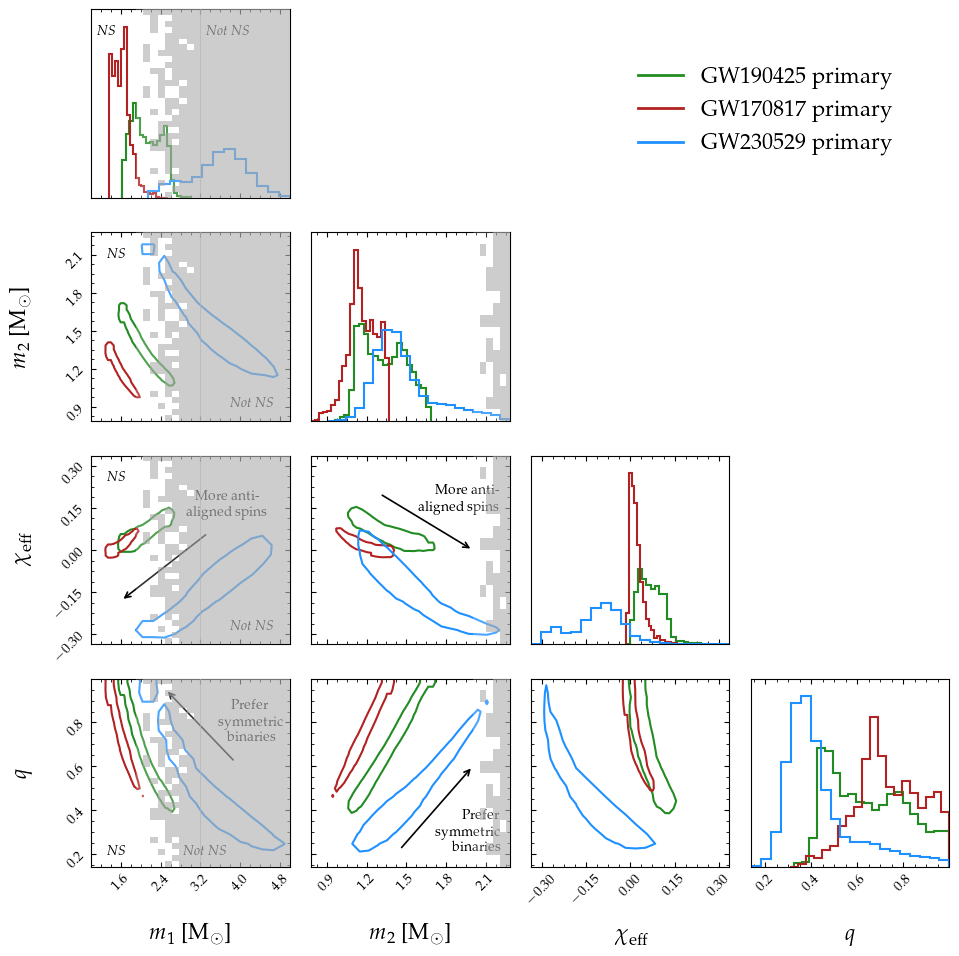

In [350]:
# PE Plot
def add_checker_region(ax, x0, x1, ncols=12, nrows=6,
                       light_alpha=0.20, dark="0.75", dark_alpha=0.35,
                       zorder=11, seed=None):
    """
    Overlay a progressive random checker fill between x0 and x1.
    - Rightmost column is fully filled.
    - Fill fraction increases from left to right.
    """
    import matplotlib as mpl
    ymin, ymax = ax.get_ylim()
    rng = np.random.default_rng(seed)

    # Per-column fill probabilities: sparse on left, dense on right
    probs = np.linspace(0.0, 1.1, ncols)

    # Sample which cells are filled
    mask = rng.random((nrows, ncols)) < probs

    # Force rightmost column completely filled
    mask[:, -1] = True

    # Build RGBA image
    dark_rgb = mpl.colors.to_rgb(dark)
    img = np.empty((nrows, ncols, 4), dtype=float)
    img[mask] = (*dark_rgb, float(dark_alpha))   # filled
    img[~mask] = (1.0, 1.0, 1.0, float(light_alpha))  # empty

    im = ax.imshow(
        img, extent=(x0, x1, ymin, ymax),
        origin="lower", aspect="auto", interpolation="nearest",
        zorder=zorder
    )
    im.set_clip_on(True)


folder_path = "../samples/"
paths = ["GW190425_C01:IMRPhenomPv2_NRTidal:HighSpin.csv.gz", "GW170817_IMRPhenomPv2NRT_highSpin_posterior.csv.gz", "GW230529_Combined_PHM_highSpin.csv.gz"]
components = [1, 2, 1]
event_labels = ["GW190425 primary", "GW170817 primary", "GW230529 primary"]
event_colors = [event_component_colors[name_to_key(name)] for name in event_labels]

# Read in csv files
dfs = [pd.read_csv(folder_path + path) for path in paths]

for i in range(len(dfs)):
    curr = dfs[i]
    mass1_source_arr = curr["mass1_source"]
    mass2_source_arr = curr["mass2_source"]
    a1_arr = curr["spin1_magnitude"]
    costilt1_arr = np.cos(curr["spin1_polar_angle"])
    a2_arr = curr["spin2_magnitude"]
    costilt2_arr = np.cos(curr["spin2_polar_angle"])

    mass_ratio_arr = mass2_source_arr / mass1_source_arr
    chi_eff_arr = (mass1_source_arr*a1_arr*(costilt1_arr) + mass2_source_arr*a2_arr*costilt2_arr)/(mass1_source_arr + mass2_source_arr)
    curr["chi_eff"] = chi_eff_arr
    curr["mass_ratio"] = mass_ratio_arr
    dfs[i] = curr


GW190425_arr = np.array([dfs[0]["mass1_source"], dfs[0]["mass2_source"], dfs[0]["chi_eff"], dfs[0]["mass_ratio"]])
GW170817_arr = np.array([dfs[1]["mass1_source"], dfs[1]["mass2_source"], dfs[1]["chi_eff"], dfs[1]["mass_ratio"]])
GW230529_arr = np.array([dfs[2]["mass1_source"], dfs[2]["mass2_source"], dfs[2]["chi_eff"], dfs[2]["mass_ratio"]])

plt.figure(figsize = (6,6), dpi=300)
corner_labels = [r'$m_1$ [M$_\odot$]', r'$m_2$ [M$_\odot$]', r'$\chi_{\mathrm{eff}}$', r'$q$']
corner_fig = None
num_events = len(dfs)
colors = event_colors
corner_params_lst = [GW190425_arr, GW170817_arr, GW230529_arr]
cred = 0.9
for i in range(num_events):
    corner_params = corner_params_lst[i]
    corner_fig = corner.corner(
        corner_params.T,
        fig=corner_fig,
        labels=corner_labels if i == 0 else None,
        show_titles=False,
        label_kwargs={"fontsize": 16},
        plot_density=False,
        plot_datapoints=False,
        hist_kwargs={"histtype": "step", "density": True, "color": colors[i], "linewidth": 1.5},
        plot_contours=True,
        fill_contours=False,
        levels=[cred],
        contour_kwargs={'colors': [colors[i]], 'linewidths': 1.5},
        smooth=0.5
    )


legend_elements = [
    Line2D([0], [0], color=event_colors[i], lw=2, label=event_labels[i])
    for i in range(num_events)
]

corner_fig.legend(
    handles=legend_elements,
    loc='upper right',
    fontsize=16,
    frameon=False,
    bbox_to_anchor=(0.98, 0.98),
    borderaxespad=2
)


axes = corner_fig.axes
N = 32
C_ROW = N ; C_COL = N
C_MIN = 1.9 ; C_MAX = 3.2
c = "0.7"
for i in [0, 4, 8, 12]:
    axes[i].set_xlim(1.0, 5.0)
    add_checker_region(
        axes[i], C_MIN, C_MAX, ncols=int(C_COL/3.5), nrows=C_ROW,
        dark=c, dark_alpha=0.65, seed=42
    )
    axes[i].axvspan(C_MAX, 7.0, color=c, alpha=0.65, lw=0, zorder=12)

for i in [5, 9, 13]:
    add_checker_region(
        axes[i], C_MIN+0.1, 2.3, ncols=int(C_COL/5), nrows=int(C_ROW/2),
        dark=c, dark_alpha=0.65, seed=42
    )
    axes[i].axvspan(C_MAX, 7.0, color=c, alpha=0.65, lw=0, zorder=12)


# ax ticks go in, also minor ticks on
for ax in corner_fig.get_axes():
    ax.tick_params(which='both', direction='in', top=True, right=True, left=True, bottom=True)
    ax.minorticks_on()

# Xeff vs m1
ax = axes[8]
ax.annotate("", xy=(1.60, -0.18), xytext=(3.35, 0.06),
            textcoords="data", arrowprops=dict(arrowstyle="->", lw=1.2))
ax.text(3.74, 0.16, "More anti-\naligned spins", fontsize=10, ha="center", va="center")

# Xeff vs m2
ax = axes[9]
ax.annotate("", xy=(2.00, 0.00), xytext=(1.30, 0.20),
            textcoords="data", arrowprops=dict(arrowstyle="->", lw=1.2))
ax.text(2.20, 0.18, "More anti-\naligned spins", fontsize=10, ha="right", va="center")

# q vs m1
ax = axes[12]
ax.annotate("", xy=(2.5, 0.95), xytext=(3.90, 0.62),
            textcoords="data",
            arrowprops=dict(arrowstyle="->", lw=1.2))
ax.text(4.20, 0.80, "Prefer\nsymmetric\nbinaries", fontsize=10, ha="center", va="center")

# q vs m2
ax = axes[13]
ax.annotate("", xy=(2.0, 0.6), xytext=(1.45, 0.22),
            textcoords="data", arrowprops=dict(arrowstyle="->", lw=1.2))
ax.text(2.20, 0.30, "Prefer\nsymmetric\nbinaries", fontsize=10, ha="right", va="center")

not_ns = r"\textit{Not NS}"
ns_str = r"\textit{NS}"

ax_idx = 0
ax = axes[ax_idx]
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.text(xmin + 0.03*(xmax-xmin), ymin + 0.85*(ymax-ymin), ns_str, fontsize=10, ha="left", va="bottom")
ax.text(xmin + 0.58*(xmax-xmin), ymin + 0.85*(ymax-ymin), not_ns, fontsize=10, ha="left", va="bottom")

ax_idx = 4
ax = axes[ax_idx]
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.text(xmin + 0.08*(xmax-xmin), ymin + 0.85*(ymax-ymin), ns_str, fontsize=10, ha="left", va="bottom")
ax.text(xmin + 0.70*(xmax-xmin), ymin + 0.06*(ymax-ymin), not_ns, fontsize=10, ha="left", va="bottom")

ax_idx = 8
ax = axes[ax_idx]
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.text(xmin + 0.08*(xmax-xmin), ymin + 0.85*(ymax-ymin), ns_str, fontsize=10, ha="left", va="bottom")
ax.text(xmin + 0.70*(xmax-xmin), ymin + 0.06*(ymax-ymin), not_ns, fontsize=10, ha="left", va="bottom")

ax_idx = 12
ax = axes[ax_idx]
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.text(xmin + 0.08*(xmax-xmin), ymin + 0.05*(ymax-ymin), ns_str, fontsize=10, ha="left", va="bottom")
ax.text(xmin + 0.46*(xmax-xmin), ymin + 0.05*(ymax-ymin), not_ns, fontsize=10, ha="left", va="bottom")


plt.tight_layout()
plt.savefig("plots/pe.png", dpi = 300)
